# Prepare for differential gene analysis

### 1.Input the feature count results

In [1]:
ALLdata <- "/data2/luj/TB-SD_NS/01.cleandata/featureCount_output.final//count.txt"
# Import gene counts table
# - skip first row (general command info)
# - make row names the gene identifiers
ALLdata <- read.table(ALLdata, header = TRUE, row.names =1, sep="\t" ,check.names = F)

colnames(ALLdata) <- basename(colnames(ALLdata))
colnames(ALLdata) <- gsub("Aligned.sortedByCoord.out.bam", "", colnames(ALLdata), fixed = T)
# Remove length/char columns
countdata <- ALLdata[ ,c(-1:-5)]

In [2]:
### Read the RPKM table
RPKM <- "/data2/luj/TB-SD_NS/01.cleandata/featureCount_output.final//count2tpm.txt"
RPKM_data <- read.table(RPKM, header = TRUE, row.names =1, sep="\t" ,check.names = F)
colnames(RPKM_data) <- basename(colnames(RPKM_data))
colnames(RPKM_data) <- gsub("Aligned.sortedByCoord.out.bam", "", colnames(RPKM_data), fixed = T)
# Remove length/char columns
rpkmdata <- RPKM_data[ ,c(-1:-5)]

### 2.Input the patients' information

In [3]:
# Import metadata file
# - make row names the matching sampleID's from the countdata
metadata <- "/data2/luj/TB-SD_NS/01.cleandata/TB-SD-CA-info.txt"
metadata <- read.delim(metadata, row.names = 1)

# Add sampleID's to the mapping file
metadata$sampleid <- row.names(metadata)

# Reorder sampleID's to match featureCounts column order. 
metadata <- na.omit(metadata[match(colnames(countdata), metadata$sampleid),])

countdata <- countdata[,metadata$sampleid]

# Differential gene expression analysis

In [4]:
## Load gene Anotation information from Database
library(AnnotationHub)
hub <- AnnotationHub()
query(hub, c("EnsDb", "Homo sapiens"))
ensdb <- hub[["AH57757"]]

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

snapshotDate(): 2017-10-27


AnnotationHub with 4 records
# snapshotDate(): 2017-10-27 
# $dataprovider: Ensembl
# $species: Homo sapiens
# $rdataclass: EnsDb
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH53211"]]' 

            title                            
  AH53211 | Ensembl 87 EnsDb for Homo Sapiens
  AH53715 | Ensembl 88 EnsDb for Homo Sapiens
  AH56681 | Ensembl 89 EnsDb for Homo Sapiens
  AH57757 | Ensembl 90 EnsDb for Homo Sapiens

require(“ensembldb”)
loading from cache '/home/luj//.AnnotationHub/64495'


## 1. Make DESeq2 object from counts and patients' information

In [5]:
suppressMessages(library(DESeq2))
suppressMessages(library(edgeR))
# using counts per million (CPM) for filtering out genes in at least one sample above minCounts (default).
# CPM matrix
# N samples > minCounts
minCounts <- 0.5
NminSamples <- 2
x <- countdata[ which( apply( cpm(DGEList(counts = countdata)), 1,function(y) sum(y>=minCounts)) >= NminSamples ) , ] 

# - countData : count dataframe
# - colData : sample metadata in the dataframe with row names as sampleID's
# - design : The design of the comparisons to use. 
#            Use (~) before the name of the column variable to compare
metadata$Group <- factor(metadata$Group , levels = c("Cancer","TB","SD","Control"))
ddsMat <- DESeqDataSetFromMatrix(countData = x,
                                 colData = metadata,
                                 design = ~Group)
ddss <- estimateSizeFactors(ddsMat)

it appears that the last variable in the design formula, 'Group',
  has a factor level, 'Control', which is not the reference level. we recommend
  to use factor(...,levels=...) or relevel() to set this as the reference level
  before proceeding. for more information, please see the 'Note on factor levels'
  in vignette('DESeq2').


In [6]:
# Convert all samples to rlog
ddsMat_rlog <- rlog(ddss, blind = FALSE)

In [7]:
# Find differential expressed genes
ddsMats <- DESeq(ddsMat)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## 2.Comparsion Analysis

In [8]:
Compare_results <- function(Disease1,Disease2,pAdjustMethod ="fdr",alpha=0.01,ensdb = ensdb){
    ## Get results from testing with FDR adjust pvalues
    results <- results(ddsMats,contrast=c("Group",Disease1,Disease2),pAdjustMethod = pAdjustMethod ,alpha = alpha)
    # Add gene full name
    results$description <- mapIds(x = ensdb,
                                  keys = row.names(results),
                                  column = "DESCRIPTION",
                                  keytype = "GENEID",
                                  multiVals = "first")
    
    # Add ENTREZ ID
    results$entrez <- mapIds(x = ensdb,
                             keys = row.names(results),
                             column = "ENTREZID",
                             keytype = "GENEID",
                             multiVals = "first")
    # Add GENENAME
    results$genename<- mapIds(x = ensdb,
                              keys = row.names(results),
                              column = "GENENAME",
                              keytype = "GENEID",
                              multiVals = "first")
    # Add GENEBIOTYPE
    results$type<- mapIds(x = ensdb,
                          keys = row.names(results),
                          column = "GENEBIOTYPE",
                          keytype = "GENEID",
                          multiVals = "first")
    return(results)
}

In [9]:
mapid <- function(enrichment){
    IDs <- function(x){unname(mapIds(x = ensdb,keys =unlist(strsplit(x,"/")),
                column = "GENENAME",keytype = "ENTREZID",multiVals = "first"))}
    data <- as.data.frame(enrichment)
    new_col <- lapply(data$geneID,function(x){paste(IDs(x),collapse = "/")})
    data$GENENAME <- unlist(new_col)
    return(data)
}
GSEA_mapid <- function(enrichment){
    IDs <- function(x){unname(mapIds(x = ensdb,keys =unlist(strsplit(x,"/")),
                column = "GENENAME",keytype = "ENTREZID",multiVals = "first"))}
    data <- as.data.frame(enrichment)
    new_col <- lapply(data$core_enrichment,function(x){paste(IDs(x),collapse = "/")})
    data$GENENAME <- unlist(new_col)
    return(data)
}

### 1.Comparsion between Cancer and Normal patients

In [10]:
C_N_results <- Compare_results("Cancer","Control",pAdjustMethod ="fdr",alpha=0.01,ensdb = ensdb)
C_N_results <- C_N_results[order(C_N_results$log2FoldChange,decreasing = T),]
C_N_results <- subset(C_N_results, is.na(padj) == FALSE)

In [11]:
write.table(C_N_results,"Cancer-Control_full.xls",sep = "\t",quote = F)

In [12]:
C_N_results <- subset(C_N_results,type=="protein_coding")

In [13]:
###################################################
## Due to the heterogeneity, we set the higher pvalue to find the more differetial genes
## find the significant differential gene
C_N_results_sig <- subset(C_N_results, padj<0.1 &abs(log2FoldChange)>1)
C_N_results_sig <- C_N_results_sig[order(C_N_results_sig$log2FoldChange,decreasing = T),]

In [14]:
write.table(C_N_results_sig,"Cancer-Control.xls",sep = "\t",quote = F)

In [15]:
require(clusterProfiler)
require(DOSE)
require(org.Hs.eg.db)

Loading required package: clusterProfiler
Loading required package: DOSE

DOSE v3.4.0  For help: https://guangchuangyu.github.io/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609

clusterProfiler v3.6.0  For help: https://guangchuangyu.github.io/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu., Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.
Loading required package: org.Hs.eg.db



In [16]:
C_N_results_sig_gsea <- subset(C_N_results_sig, is.na(entrez) == FALSE)
#actually use full gene
#results_sig_gsea <- subset(results, is.na(entrez) == FALSE)

# Create a matrix of gene log2 fold changes
C_N_gene_matrix_gsea <- C_N_results_sig_gsea$log2FoldChange

# Add the entrezID's as names for each logFC entry
names(C_N_gene_matrix_gsea) <- C_N_results_sig_gsea$entrez

# View the format of the gene matrix
##- Names = ENTREZ ID
##- Values = Log2 Fold changes
#head(C_N_gene_matrix_gsea)

In [17]:
C_N_BP <- enrichGO(gene = names(C_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
C_N_CC <- enrichGO(gene = names(C_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
C_N_MF <- enrichGO(gene = names(C_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [18]:
library(ggplot2)
library(stringr)
C_N_BP_plot <- C_N_BP[order(C_N_BP$pvalue),]
p <- ggplot(C_N_BP_plot[1:15,],aes(x=reorder(paste(ID,Description),-pvalue),y=-log10(pvalue)))+
  geom_bar(stat = "identity",position = "dodge",width = 0.7,fill="black")+coord_flip()+
  scale_x_discrete(labels=function(x) str_wrap(x, width=40))+
  ylab("-log10(P-value)")+xlab("Pathway")+
  theme(panel.grid.major =element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.title = element_text(size = rel(1)),
        plot.title = element_text(size = rel(3),face = "bold",hjust = 0.3),
        axis.line.x = element_line(),
       axis.ticks.y=element_blank())+
      scale_y_continuous(limits = c(0,20),expand = c(0, 0),position = "top")+
  guides(fill=F)

In [19]:
write.table(mapid(C_N_BP),"Cancer-Control_BP.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(C_N_MF),"Cancer-Control_MF.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(C_N_CC),"Cancer-Control_CC.xls",sep = "\t",quote = F,row.names = F)

In [20]:
C_N_KEGG <- enrichKEGG(gene = names(C_N_gene_matrix_gsea),
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [21]:
write.table(mapid(C_N_KEGG),"Cancer-Control_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [22]:
pdf("C_N_KEGG.pdf",height=10,width=10)
dotplot(C_N_KEGG,showCategory = 25,font.size=12)
dev.off()

png 
  2

In [23]:
library(ReactomePA)
C_N_reactome <- enrichPathway(gene=names(C_N_gene_matrix_gsea),qvalueCutoff=0.05, organism = "human")

ReactomePA v1.22.0  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479


In [24]:
pdf("C_N_reactome_pathway.pdf",height=10,width=10)
dotplot(C_N_reactome,font.size=8,showCategory = 25)
dev.off()

png 
  2

In [25]:
write.table(mapid(C_N_reactome),"Cancer-Control_Reactome.xls",sep = "\t",quote = F,row.names = F)

In [26]:
# Gather first number significant genes and make matrix
library(pheatmap)
names <- row.names(C_N_results_sig)

mat <- rpkmdata[names,orders]

# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata[metadata$Group=="Cancer"|metadata$Group=="Control",]$Group), 
  row.names = as.character(metadata[metadata$Group=="Cancer"|metadata$Group=="Control",]$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue",Cancer="pink")
)

# Make Heatmap with pheatmap function.
## See more in documentation for customization
pheatmap(mat = mat, 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         #cluster_cols=F,
         show_rownames=F,height=15,fontsize = 15,filename="cancer.pdf",
         width=15)

### 2.Comparsion between Tuberculosis and Normal patients

In [27]:
## Get results from testing with FDR adjust pvalues
T_N_results <- Compare_results("TB","Control",pAdjustMethod ="fdr",alpha=0.01,ensdb = ensdb)
T_N_results <- T_N_results[order(T_N_results$log2FoldChange,decreasing = TRUE),]
T_N_results <- subset(T_N_results, is.na(padj) == FALSE)
#head(T_N_results)

In [28]:
write.table(T_N_results,"TB-Control_full.xls",sep = "\t",quote = F)

In [29]:
T_N_results <- subset(T_N_results,type=="protein_coding")

In [30]:
# find the significant differential gene
###################################################
## Due to the heterogeneity, we set the higher pvalue to find the more differetial genes
T_N_results_sig <- subset(T_N_results, padj < 0.1 &abs(log2FoldChange)>1)
T_N_results_sig <- T_N_results_sig[order(T_N_results_sig$log2FoldChange,decreasing = T),]
#head(T_N_results_sig)
#dim(T_N_results_sig)

In [31]:
write.table(as.data.frame(T_N_results_sig),"TB-Control.xls",sep = "\t",quote = F)

In [32]:
T_N_results_sig_gsea <- subset(T_N_results_sig, is.na(entrez) == FALSE)
#actually use full gene
#results_sig_gsea <- subset(results, is.na(entrez) == FALSE)

# Create a matrix of gene log2 fold changes
T_N_gene_matrix_gsea <- T_N_results_sig_gsea$log2FoldChange

# Add the entrezID's as names for each logFC entry
names(T_N_gene_matrix_gsea) <- T_N_results_sig_gsea$entrez

# View the format of the gene matrix
##- Names = ENTREZ ID
##- Values = Log2 Fold changes
#head(T_N_gene_matrix_gsea)

In [33]:
T_N_BP <- enrichGO(gene = names(T_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_N_CC <- enrichGO(gene = names(T_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_N_MF <- enrichGO(gene = names(T_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [34]:
capitalize_all <- Vectorize(function(x) {
  x <- str_wrap(x, width=40)
  s <- strsplit(x, " ")[[1]]
  paste(toupper(substring(s, 1,1)), substring(s, 2), sep="", collapse=" ")
})
T_N_BP_plot <- T_N_BP[order(T_N_BP$pvalue),]
T_N_BP_plot <- T_N_BP_plot[c("GO:0001501","GO:0048705","GO:0051216","GO:0060348","GO:0001503","GO:0002063",
                            "GO:0001958","GO:0036075","GO:0060346","GO:0060350","GO:0002062","GO:0060349",
                             "GO:0048706","GO:0061430"),]
pdf("T_N_BP_plot.pdf")
ggplot(T_N_BP_plot,aes(x=reorder(Description,-pvalue),y=-log10(pvalue)))+
  geom_bar(stat = "identity",position = "dodge",width = 0.7,fill="#F97164")+coord_flip()+
  ylab("-log10(P-value)")+xlab("")+scale_x_discrete(element_blank(), labels=capitalize_all) +
  theme(panel.grid.major =element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.title = element_text(size = rel(1.1)),
        plot.title = element_text(size = rel(3),face = "bold",hjust = 0.3),
        axis.line = element_line(),axis.text.y=element_text(size=10,hjust=0,margin = margin(r = -200),face = "bold"),
       axis.ticks.y=element_blank())+
      scale_y_continuous(limits = c(0,15),expand = c(0, 0),position = "top")+
  guides(fill=F)
dev.off()

png 
  2

In [35]:
write.table(mapid(T_N_BP),"TB-Control_BP.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(T_N_MF),"TB-Control_MF.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(T_N_CC),"TB-Control_CC.xls",sep = "\t",quote = F,row.names = F)

In [36]:
T_N_KEGG <- enrichKEGG(gene = names(T_N_gene_matrix_gsea),
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [37]:
write.table(mapid(T_N_KEGG),"TB-Control_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [38]:
pdf("T_N_KEGG.pdf",height=10,width=10)
dotplot(T_N_KEGG,showCategory=25,font.size=12)
dev.off()

png 
  2

In [39]:
library(ReactomePA)
T_N_reactome <- enrichPathway(gene=names(T_N_gene_matrix_gsea),qvalueCutoff=0.01, organism = "human")

In [40]:
pdf("T_N_reactome_pathway.pdf",height=10,width=10)
dotplot(T_N_reactome,showCategory=25,font.size=12)
dev.off()

png 
  2

In [41]:
write.table(mapid(T_N_reactome),"TB-Control_Reactome.xls",sep = "\t",quote = F,row.names = F)

In [42]:
# Gather first number significant genes and make matrix
library(pheatmap)
T_N_hp <- unique(unlist(strsplit(mapid(T_N_reactome)[1:5,"GENENAME"],"/")))
mat <- rpkmdata[unname(mapIds(x = ensdb,keys =T_N_hp,
                column = "GENEID",keytype = "GENENAME",multiVals = "first")),orders]
row.names(mat) <- T_N_hp
# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue",TB="darkgreen")
)

# Make Heatmap with pheatmap function.
## See more in documentation for customization
pheatmap(mat = mat, 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         #cluster_cols=F,
         cluster_cols=dendextend::rotate(hclust(dist(cor(mat))),c(1:10)),
         #show_rownames=F,
         height=15,fontsize = 10,filename="TB-ECM.pdf",
         width=15)

In [43]:
# Gather first number significant genes and make matrix
library(pheatmap)
names <- row.names(T_N_results_sig)

mat <- rpkmdata[names,orders]

# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue",TB="darkgreen")
)

# Make Heatmap with pheatmap function.
## See more in documentation for customization
pheatmap(mat = mat, 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         #cluster_cols=F,
         cluster_cols=dendextend::rotate(hclust(dist(cor(mat))),c(1:10)),
         show_rownames=F,height=15,fontsize = 15,filename="TB.pdf",
         width=15)

### 3.Comparsion between Normal and Sarcoidosis

In [44]:
S_N_results <- Compare_results("SD","Control",pAdjustMethod ="fdr",alpha=0.01,ensdb = ensdb)
S_N_results <- S_N_results[order(S_N_results$log2FoldChange,decreasing = T),]
S_N_results <- subset(S_N_results, is.na(padj) == FALSE)
#head(S_N_results)

In [45]:
write.table(S_N_results,"SD-Control_full.xls",sep = "\t",quote = F)

In [46]:
S_N_results <- subset(S_N_results,type=="protein_coding")

In [47]:
## find the significant differential gene
###################################################
## Due to the heterogeneity, we set the higher fdr to find the more differetial genes
S_N_results_sig <- subset(S_N_results, padj<0.1 &abs(log2FoldChange)>1)
S_N_results_sig <- S_N_results_sig[order(S_N_results_sig$log2FoldChange,decreasing = T),]
#head(S_N_results_sig)
#dim(S_N_results_sig)

In [48]:
write.table(S_N_results_sig,"SD-Control.xls",sep = "\t",quote = F)

In [49]:
# for ordered GSEA
# Remove any genes that do not have any entrez identifiers
S_N_results_sig_gsea <- subset(S_N_results_sig, is.na(entrez) == FALSE)
#actually use full gene
#results_sig_gsea <- subset(results, is.na(entrez) == FALSE)

# Create a matrix of gene log2 fold changes
S_N_gene_matrix_gsea <- S_N_results_sig_gsea$log2FoldChange

# Add the entrezID's as names for each logFC entry
names(S_N_gene_matrix_gsea) <- S_N_results_sig_gsea$entrez

# View the format of the gene matrix
##- Names = ENTREZ ID
##- Values = Log2 Fold changes
head(S_N_gene_matrix_gsea)

9407     23581     63950     79802       190      6318 
19.864712 19.771909 18.514420  9.518766  9.224370  9.221476

In [50]:
S_N_BP <- enrichGO(gene = names(S_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
S_N_CC <- enrichGO(gene = names(S_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
S_N_MF <- enrichGO(gene = names(S_N_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [51]:
write.table(mapid(S_N_BP),"SD-Control_BP.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(S_N_MF),"SD-Control_MF.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(S_N_CC),"SD-Control_CC.xls",sep = "\t",quote = F,row.names = F)

In [52]:
S_N_KEGG <- enrichKEGG(gene = names(S_N_gene_matrix_gsea),
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 1,
                       qvalueCutoff  = 1, use_internal_data=F)

In [53]:
write.table(mapid(S_N_KEGG),"SD-Control_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [54]:
S_N_reactome <- enrichPathway(gene=names(S_N_gene_matrix_gsea),qvalueCutoff=1, organism = "human")

In [55]:
pdf("S_N_reactome_pathway.pdf",height=10,width=10)
dotplot(S_N_reactome,showCategory=25,font.size=12)
dev.off()

png 
  2

In [56]:
write.table(mapid(S_N_reactome),"SD-Control_reactome.xls",sep = "\t",quote = F,row.names = F)

In [57]:
# Gather first number significant genes and make matrix
library(pheatmap)
names <- row.names(S_N_results_sig)

mat <- rpkmdata[names,orders]

# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue", SD="purple")
)

# Make Heatmap with pheatmap function.
## See more in documentation for customization
pheatmap(mat = mat, 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         #cluster_cols=F,
         show_rownames=F,height=15,fontsize = 15,filename="SD.pdf",
         width=15)

In [58]:
ECM_gene <- as.character(read.table("/data2/luj/GSEA/homo/REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION.gmt",stringsAsFactors = F)[1,c(-1,-2)])

In [59]:
T_group <- rbind(metadata[metadata$Group=="Control",],metadata[metadata$Group=="SD",],metadata[metadata$Group=="TB",])

In [60]:
T_group[,1] <- as.character(T_group[,1])
T_expr <- rpkmdata[,T_group$sampleid]
T_expr <-T_expr[apply(T_expr,1,sum)>0.5,]
T_expr$genename<- mapIds(x = ensdb,
                              keys = row.names(T_expr),
                              column = "GENENAME",
                              keytype = "GENEID",
                              multiVals = "first")
T_expr <- T_expr[!duplicated(T_expr$genename),]
row.names(T_expr) <- T_expr$genename
T_rpkm <-  T_expr[,colnames(T_expr)!="genename"]
T_rpkm <- T_rpkm[,row.names(T_group)]

In [61]:
T_N_result_ECM <- subset(T_N_results, is.na(entrez) == FALSE&genename%in%ECM_gene)
S_N_result_ECM <- subset(S_N_results, is.na(entrez) == FALSE&genename%in%ECM_gene)

In [62]:
ECM_name<-c(intersect(subset(T_N_result_ECM,log2FoldChange>0)$genename,subset(S_N_result_ECM,log2FoldChange>0)$genename),
intersect(subset(T_N_result_ECM,log2FoldChange<0)$genename,subset(S_N_result_ECM,log2FoldChange<0)$genename))

In [63]:
mat <- T_rpkm

In [64]:
mat <- na.omit(T_rpkm[ECM_gene,order])
# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue",TB="darkgreen",SD="pink")
)

# Make Heatmap with pheatmap function.
## See more in documentation for customization
pheatmap(mat = mat,
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         fontsize = 12, # Make fonts smaller
         cellwidth = 20, # Make the cells wider
         cellheight = 10,
         cluster_rows=hclust(dist(cor(t(mat)),method = "minkowski")),
         cluster_cols=dendextend::rotate(hclust(dist(t(mat))),rev(c(1:15))),
         #show_rownames=F,
         height=15,filename="TBSDECM.pdf",
         width=15)

### 4.Comparsion between Tuberculosis and Cancer patients

In [65]:
C_T_results <- Compare_results("Cancer","TB",pAdjustMethod ="fdr",alpha=0.01,ensdb = ensdb)
C_T_results <- C_T_results[order(C_T_results$log2FoldChange,decreasing = TRUE),]
#head(C_T_results)

In [66]:
write.table(C_T_results,"Cancer-TB_full.xls",sep = "\t",quote = F)

In [67]:
## find the significant differential gene
###################################################
## Due to the heterogeneity, we set the higher fdr to find the more differetial genes
C_T_results_sig <- subset(C_T_results, padj<0.1 &abs(log2FoldChange)>1)
C_T_results_sig <- C_T_results_sig[order(C_T_results_sig$log2FoldChange,decreasing = TRUE),]
#head(C_T_results_sig)
#dim(C_T_results_sig)

In [68]:
write.table(C_T_results_sig,"Cancer-TB.xls",sep = "\t",quote = F)

In [69]:
# for ordered GSEA
# Remove any genes that do not have any entrez identifiers
C_T_results_sig_gsea <- subset(C_T_results_sig, is.na(entrez) == FALSE)
#actually use full gene
#results_sig_gsea <- subset(results, is.na(entrez) == FALSE)

# Create a matrix of gene log2 fold changes
C_T_gene_matrix_gsea <- C_T_results_sig_gsea$log2FoldChange

# Add the entrezID's as names for each logFC entry
names(C_T_gene_matrix_gsea) <- C_T_results_sig_gsea$entrez

# View the format of the gene matrix
##- Names = ENTREZ ID
##- Values = Log2 Fold changes
head(C_T_gene_matrix_gsea)

4102     28234      8581    652995     84985    653220 
11.285191  9.717656  9.241521  9.175833  9.163424  9.136763

In [70]:
C_T_BP <- enrichGO(gene = names(C_T_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
C_T_CC <- enrichGO(gene = names(C_T_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
C_T_MF <- enrichGO(gene = names(C_T_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [71]:
write.table(mapid(C_T_BP),"Cancer-TB_BP.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(C_T_MF),"Cancer-TB_MF.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(C_T_CC),"Cancer-TB_CC.xls",sep = "\t",quote = F,row.names = F)

In [72]:
C_T_KEGG <- enrichKEGG(gene = names(C_T_gene_matrix_gsea),
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [73]:
write.table(mapid(C_T_KEGG),"Cancer-TB_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [74]:
C_T_ALL <- subset(C_T_results, is.na(entrez) == FALSE)
C_T_All <- C_T_ALL$log2FoldChange
names(C_T_All) <- C_T_ALL$entrez
C_T_GSEA <- gseKEGG(geneList = C_T_All,
               organism     = 'hsa',
               nPerm        = 5000,
               minGSSize    = 10,
               pvalueCutoff = 0.5,
               verbose      = FALSE)

In [75]:
write.table(GSEA_mapid(C_T_GSEA),"Cancer-TB_GSEA.xls",sep='\t',row.names=F)

### 5.Comparsion between Sarcoidosis and Tuberculosis patients

In [76]:
S_T_results <- Compare_results("SD","TB",pAdjustMethod ="fdr",alpha=0.01,ensdb = ensdb)
S_T_results <- S_T_results[order(S_T_results$log2FoldChange,decreasing = TRUE),]
#head(S_T_results)

In [77]:
write.table(S_T_results,"SD-TB_full.xls",sep = "\t",quote = F)

In [78]:
## find the significant differential gene
###################################################
## Due to the heterogeneity, we set the higher fdr to find the more differetial genes
S_T_results_sig <- subset(S_T_results, padj<0.1 &abs(log2FoldChange)>1)
S_T_results_sig <- S_T_results_sig[order(S_T_results_sig$log2FoldChange,decreasing = TRUE),]
#head(S_T_results_sig)
#dim(S_T_results_sig)

In [79]:
write.table(S_T_results_sig,"SD-TB.xls",sep = "\t",quote = F)

In [80]:
# for ordered GSEA
# Remove any genes that do not have any entrez identifiers
S_T_results_sig_gsea <- subset(S_T_results_sig, is.na(entrez) == FALSE)
#actually use full gene
#results_sig_gsea <- subset(results, is.na(entrez) == FALSE)

# Create a matrix of gene log2 fold changes
S_T_gene_matrix_gsea <- S_T_results_sig_gsea$log2FoldChange

# Add the entrezID's as names for each logFC entry
names(S_T_gene_matrix_gsea) <- S_T_results_sig_gsea$entrez

# View the format of the gene matrix
##- Names = ENTREZ ID
##- Values = Log2 Fold changes
head(S_T_gene_matrix_gsea)

101409253 101927136      2267      7503      4586      5126 
28.147337 12.447742 11.786400 10.245334  9.622475  9.337182

In [81]:
S_T_BP <- enrichGO(gene = names(S_T_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
S_T_CC <- enrichGO(gene = names(S_T_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
S_T_MF <- enrichGO(gene = names(S_T_gene_matrix_gsea),
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [82]:
write.table(mapid(S_T_BP),"SD-TB_BP.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(S_T_MF),"SD-TB_MF.xls",sep = "\t",quote = F,row.names = F)
write.table(mapid(S_T_CC),"SD-TB_CC.xls",sep = "\t",quote = F,row.names = F)

In [83]:
S_T_KEGG <- enrichKEGG(gene = names(S_T_gene_matrix_gsea),
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [84]:
write.table(mapid(S_T_KEGG),"SD-TB_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [85]:
S_T_reactome <- enrichPathway(gene=names(S_T_gene_matrix_gsea),qvalueCutoff=0.05, organism = "human")

### 5.Comparsion between Sarcoidosis and Tuberculosis patients

In [86]:
S_C_results <- Compare_results("SD","Cancer",pAdjustMethod ="fdr",alpha=0.01,ensdb = ensdb)
S_C_results <- S_C_results[order(S_C_results$log2FoldChange,decreasing = TRUE),]
#head(S_C_results)

In [87]:
## find the significant differential gene
###################################################
## Due to the heterogeneity, we set the higher fdr to find the more differetial genes
S_C_results_sig <- subset(S_C_results, padj<0.1 &abs(log2FoldChange)>1)
S_C_results_sig <- S_C_results_sig[order(S_C_results_sig$log2FoldChange,decreasing = TRUE),]
#head(S_C_results_sig)
#dim(S_C_results_sig)

## 3. TB/Normal & Cancer/Normal  Analysis

In [88]:
annotation <- function(DEGs){
    ALL_intersect_genes <- data.frame(ENTREZID=DEGs)
    ALL_intersect_genes$description <- mapIds(x = ensdb,
                                              keys = DEGs,
                                              column = "DESCRIPTION",
                                              keytype = "ENTREZID",
                                              multiVals = "first")
    ALL_intersect_genes$genename<- mapIds(x = ensdb,
                                          keys = DEGs,
                                          column = "GENENAME",
                                          keytype = "ENTREZID",
                                          multiVals = "first")
    return(ALL_intersect_genes)
}

### 1. TB/Normal & Cancer/Normal Common Genes

#### 1. TB/Normal & Cancer/Normal significant gene all up regulated

In [89]:
T_C_intersect_up <- intersect(names(C_N_gene_matrix_gsea)[C_N_gene_matrix_gsea>0],
                              names(T_N_gene_matrix_gsea)[T_N_gene_matrix_gsea>0])
T_C_intersect_up <- annotation(T_C_intersect_up)

In [90]:
head(T_C_intersect_up)
dim(T_C_intersect_up)

ENTREZID,description,genename
<fct>,<chr>,<chr>
23581,caspase 14 [Source:HGNC Symbol;Acc:HGNC:1502],CASP14
63950,DMRT like family A2 [Source:HGNC Symbol;Acc:HGNC:13908],DMRTA2
9407,"transmembrane protease, serine 11D [Source:HGNC Symbol;Acc:HGNC:24059]",TMPRSS11D
27201,G protein-coupled receptor 78 [Source:HGNC Symbol;Acc:HGNC:4528],GPR78
116379,interleukin 22 receptor subunit alpha 2 [Source:HGNC Symbol;Acc:HGNC:14901],IL22RA2
5307,paired like homeodomain 1 [Source:HGNC Symbol;Acc:HGNC:9004],PITX1


[1] 205   3

In [91]:
write.table(T_C_intersect_up,"TB_Cancer_up.xls",sep = "\t",quote = F)

In [92]:
T_C_up_BP <- enrichGO(gene = T_C_intersect_up$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_C_up_CC <- enrichGO(gene = T_C_intersect_up$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_C_up_MF <- enrichGO(gene = T_C_intersect_up$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [93]:
T_C_up_KEGG <- enrichKEGG(gene = T_C_intersect_up$ENTREZID,
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [94]:
write.table(mapid(T_C_up_KEGG),"T_C_up_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [95]:
T_C_up_reactome <- enrichPathway(gene=T_C_intersect_up$ENTREZID,qvalueCutoff=0.05, organism = "human")

In [96]:
write.table(mapid(T_C_up_reactome),"T_C_up_reactome.xls",sep = "\t",quote = F,row.names = F)

In [97]:
pdf("T_C_up_reactome.pdf",height=10,width=10)
dotplot(T_C_up_reactome,showCategory=25,font.size=12)
dev.off()

png 
  2

#### 2. TB/Normal & Cancer/Normal significant gene all down regulated

In [98]:
T_C_intersect_down <- intersect(names(C_N_gene_matrix_gsea)[C_N_gene_matrix_gsea<=0],
                              names(T_N_gene_matrix_gsea)[T_N_gene_matrix_gsea<=0])
T_C_intersect_down <- annotation(T_C_intersect_down)

In [99]:
head(T_C_intersect_down)
dim(T_C_intersect_down)

ENTREZID,description,genename
<fct>,<chr>,<chr>
120379,PIH1 domain containing 2 [Source:HGNC Symbol;Acc:HGNC:25210],PIH1D2
10908,patatin like phospholipase domain containing 6 [Source:HGNC Symbol;Acc:HGNC:16268],PNPLA6
9185,RALBP1 associated Eps domain containing 2 [Source:HGNC Symbol;Acc:HGNC:9963],REPS2
54986,unc-51 like kinase 4 [Source:HGNC Symbol;Acc:HGNC:15784],ULK4
896,cyclin D3 [Source:HGNC Symbol;Acc:HGNC:1585],CCND3
631,beaded filament structural protein 1 [Source:HGNC Symbol;Acc:HGNC:1040],BFSP1


[1] 126   3

In [100]:
write.table(mapid(T_C_intersect_down),"TB_Cancer_down.xls",sep = "\t",quote = F)

In [101]:
T_C_down_BP <- enrichGO(gene = T_C_intersect_down$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_C_down_CC <- enrichGO(gene = T_C_intersect_down$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_C_down_MF <- enrichGO(gene = T_C_intersect_down$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [102]:
T_C_down_KEGG <- enrichKEGG(gene = T_C_intersect_down$ENTREZID,
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [103]:
write.table(mapid(T_C_down_KEGG),"T_C_down_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [104]:
T_C_down_reactome <- enrichPathway(gene=T_C_intersect_down$ENTREZID,qvalueCutoff=0.05, organism = "human")

#### 3. TB/Normal & Cancer/Normal significant gene all

In [105]:
# Gather first number significant genes and make matrix
library(pheatmap)
T_C <- as.character(rbind(T_C_intersect_down,T_C_intersect_up)$genename)
mat <- rpkmdata[row.names(T_N_results_sig[T_N_results_sig$genename%in%T_C,]),orders]
row.names(mat) <- T_C
# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue",TB="darkgreen",Cancer="pink")
)

# Make Heatmap with pheatmap function.
## See more in documentation for customization
p <- pheatmap(mat = mat, 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         #cluster_cols=F,
         height=15,fontsize = 5,filename="TB&Cancer.pdf",
         width=15)

In [106]:
write.table(mat[p$tree_row[["order"]],p$tree_col[["order"]]],"TB_Cancer_up&down.xls",sep = "\t",quote = F)

In [107]:
T_C_intersect_updown <- intersect(names(C_N_gene_matrix_gsea),names(T_N_gene_matrix_gsea))
T_C_intersect_updown <- annotation(T_C_intersect_updown)

In [108]:
T_C_updown_BP <- enrichGO(gene = T_C_intersect_updown$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_C_updown_CC <- enrichGO(gene = T_C_intersect_updown$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_C_updown_MF <- enrichGO(gene = T_C_intersect_updown$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [109]:
T_C_updown_KEGG <- enrichKEGG(gene = T_C_intersect_updown$ENTREZID,
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [110]:
pdf("T_C_updown_KEGG.pdf",height=10,width=10)
dotplot(T_C_updown_KEGG,showCategory=25,font.size=12)
dev.off()

png 
  2

In [111]:
write.table(mapid(T_C_updown_KEGG),"T_C_updown_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [112]:
T_C_updown_reactome <- enrichPathway(gene=T_C_intersect_updown$ENTREZID,qvalueCutoff=0.05, organism = "human")

In [113]:
write.table(mapid(T_C_updown_reactome),"T_C_updown_reactome.xls",sep = "\t",quote = F,row.names = F)

In [114]:
pdf("T_C_updown_reactome.pdf",height=10,width=10)
dotplot(T_C_updown_reactome,showCategory=25,font.size=12)
dev.off()

png 
  2

#### 4. TB/Normal & SD/Normal significant gene all up regulated

In [115]:
T_S_intersect_up <- intersect(names(S_N_gene_matrix_gsea)[S_N_gene_matrix_gsea>0],
                              names(T_N_gene_matrix_gsea)[T_N_gene_matrix_gsea>0])
T_S_intersect_up <- annotation(T_S_intersect_up)

In [116]:
head(T_S_intersect_up)
dim(T_S_intersect_up)

ENTREZID,description,genename
<fct>,<chr>,<chr>
9407,"transmembrane protease, serine 11D [Source:HGNC Symbol;Acc:HGNC:24059]",TMPRSS11D
23581,caspase 14 [Source:HGNC Symbol;Acc:HGNC:1502],CASP14
63950,DMRT like family A2 [Source:HGNC Symbol;Acc:HGNC:13908],DMRTA2
4321,matrix metallopeptidase 12 [Source:HGNC Symbol;Acc:HGNC:7158],MMP12
260436,follicular dendritic cell secreted protein [Source:HGNC Symbol;Acc:HGNC:19215],FDCSP
116379,interleukin 22 receptor subunit alpha 2 [Source:HGNC Symbol;Acc:HGNC:14901],IL22RA2


[1] 191   3

In [117]:
write.table(T_S_intersect_up,"TB_SD_up.xls",sep = "\t",quote = F)

In [118]:
T_S_up_BP <- enrichGO(gene = T_S_intersect_up$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_S_up_CC <- enrichGO(gene = T_S_intersect_up$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_S_up_MF <- enrichGO(gene = T_S_intersect_up$ENTREZID,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [119]:
T_S_up_KEGG <- enrichKEGG(gene = T_S_intersect_up$ENTREZID,
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [120]:
write.table(mapid(T_S_up_KEGG),"T_S_up_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [121]:
T_S_up_reactome <- enrichPathway(gene=T_S_intersect_up$ENTREZID,qvalueCutoff=0.05, organism = "human")

In [122]:
write.table(mapid(T_S_up_reactome),"T_S_up_reactome.xls",sep = "\t",quote = F,row.names = F)

In [123]:
pdf("T_S_up_reactome.pdf",height=10,width=10)
dotplot(T_S_up_reactome,showCategory=25,font.size=12)
dev.off()

png 
  2

#### 5. TB/Normal & SD/Normal significant gene all down regulated

In [124]:
T_S_intersect_down <- intersect(names(S_N_gene_matrix_gsea)[S_N_gene_matrix_gsea<=0],
                              names(T_N_gene_matrix_gsea)[T_N_gene_matrix_gsea<=0])
T_S_intersect_down <- annotation(T_S_intersect_down)

In [125]:
write.table(T_S_intersect_down,"TB_SD_down.xls",sep = "\t",quote = F)

#### 6. TB/Normal & SD/Normal significant gene all

In [126]:
# Gather first number significant genes and make matrix
library(pheatmap)
T_S <- as.character(rbind(T_S_intersect_down,T_S_intersect_up)$genename)

mat <- rpkmdata[row.names(T_N_results_sig[T_N_results_sig$genename%in%T_S,]),orders]
row.names(mat) <- T_S
# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue",TB="darkgreen",SD="purple")
)

# Make Heatmap with pheatmap function.
## See more in documentation for customization
p <- pheatmap(mat = mat, 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         #cluster_cols=F,
         height=15,fontsize = 5,filename="TB&SD.pdf",
         width=15)

In [127]:
T_S_intersect_updown <- intersect(names(S_N_gene_matrix_gsea),
                              names(T_N_gene_matrix_gsea))
T_S_intersect_updown <- annotation(T_S_intersect_updown)

In [128]:
T_S_updown_KEGG <- enrichKEGG(gene = T_S_intersect_updown$ENTREZID,
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [129]:
pdf("T_S_updown_KEGG.pdf",height=10,width=10)
dotplot(T_S_updown_KEGG,showCategory=25,font.size=12)
dev.off()

png 
  2

In [130]:
write.table(mapid(T_S_updown_KEGG),"T_S_updown_KEGG.xls",sep = "\t",quote = F,row.names = F)

In [131]:
T_S_updown_reactome <- enrichPathway(gene=T_S_intersect_updown$ENTREZID,qvalueCutoff=0.05, organism = "human")

In [132]:
write.table(mapid(T_S_updown_reactome),"T_S_updown_reactome.xls",sep = "\t",quote = F,row.names = F)

In [133]:
pdf("T_S_updown_reactome.pdf",height=10,width=10)
dotplot(T_S_updown_reactome,showCategory=25,font.size=12)
dev.off()

png 
  2

#### 3. TB/Normal & Cancer/Normal significant different genes

In [134]:
same <- union(T_C_intersect_down$ENTREZID
              ,T_C_intersect_up$ENTREZID)
T_C_intersect_diff <- setdiff(intersect(names(T_N_gene_matrix_gsea),names(C_N_gene_matrix_gsea)),same)
head(T_C_intersect_diff)
#T_C_intersect_diff <- annotation(T_C_intersect_diff)

[1] "5502"   "477"    "123103" "29970"  "10682"  "57393"

In [135]:
#write.table(T_C_intersect_diff,"TB_Cancer_diff.xls",sep = "\t",quote = F)

### 2. Cancer/Normal DEGs but not in TB/Normal

In [136]:
CN_TN_setdiff_genes <- setdiff(names(C_N_gene_matrix_gsea),names(T_N_gene_matrix_gsea))
CN_TN_genes <- annotation(CN_TN_setdiff_genes)
head(CN_TN_genes)
dim(CN_TN_genes)

ENTREZID,description,genename
<fct>,<chr>,<chr>
8581,lymphocyte antigen 6 family member D [Source:HGNC Symbol;Acc:HGNC:13348],LY6D
6318,serpin family B member 4 [Source:HGNC Symbol;Acc:HGNC:10570],SERPINB4
1830,desmoglein 3 [Source:HGNC Symbol;Acc:HGNC:3050],DSG3
28234,solute carrier organic anion transporter family member 1B3 [Source:HGNC Symbol;Acc:HGNC:10961],SLCO1B3
84985,family with sequence similarity 83 member A [Source:HGNC Symbol;Acc:HGNC:28210],FAM83A
56033,BARX homeobox 1 [Source:HGNC Symbol;Acc:HGNC:955],BARX1


[1] 3185    3

### 3. TB/Normal DEGs but not in Cancer/Normal

In [137]:
TN_CN_setdiff_genes <- setdiff(names(T_N_gene_matrix_gsea),names(C_N_gene_matrix_gsea))
TN_CN_genes <- annotation(TN_CN_setdiff_genes)

In [138]:
head(TN_CN_genes)
dim(TN_CN_genes)

ENTREZID,description,genename
<fct>,<chr>,<chr>
70,"actin, alpha, cardiac muscle 1 [Source:HGNC Symbol;Acc:HGNC:143]",ACTC1
144453,bestrophin 3 [Source:HGNC Symbol;Acc:HGNC:17105],BEST3
6329,sodium voltage-gated channel alpha subunit 4 [Source:HGNC Symbol;Acc:HGNC:10591],SCN4A
80852,glutamate receptor interacting protein 2 [Source:HGNC Symbol;Acc:HGNC:23841],GRIP2
84940,coronin 6 [Source:HGNC Symbol;Acc:HGNC:21356],CORO6
176,aggrecan [Source:HGNC Symbol;Acc:HGNC:319],ACAN


[1] 340   3

# Differential genes visualization 

## 1.Venn diagram show the differential genes between three groups

In [139]:
library(VennDiagram)
#T<-venn.diagram(list("Cancer-Normal"=names(C_N_gene_matrix_gsea),
#                     "TB-Normal"=names(T_N_gene_matrix_gsea),
#                     "TB-Cancer"=names(T_C_gene_matrix_gsea)),
#                filename=NULL ,lwd=1,lty=2,col=c('red','green','blue'),fill=c('red','green','blue')
#                ,cat.col=c('red','green','blue')
#                ,reverse=TRUE)
venn <-venn.diagram(list("Cancer"=names(C_N_gene_matrix_gsea),
                     "Tuberculosis"=names(T_N_gene_matrix_gsea),
                "Sarcoidosis"=names(S_N_gene_matrix_gsea)),
                filename=NULL ,lwd=1,lty=2,col=c('red','green',"blue"),fill=c('red','green',"blue")
                ,cat.col=c('red','green','blue'),cex = 1.5,sub.cex = 20
                ,reverse=TRUE,margin = 0.2)
pdf("venn.pdf")
grid.draw(venn)
dev.off()

Loading required package: grid
Loading required package: futile.logger


png 
  2

In [140]:
#DEG_genes <- c(row.names(C_N_results),rownames(T_N_results),rownames(T_C_results),rownames(S_N_results))
# Gather first number significant genes and make matrix
library(pheatmap)
library(dendextend)
genename <- intersect(intersect(names(C_N_gene_matrix_gsea),names(T_N_gene_matrix_gsea)),
                          names(S_N_gene_matrix_gsea))
genename <- intersect(intersect(names(C_N_gene_matrix_gsea>0),names(T_N_gene_matrix_gsea>0)),
                          names(S_N_gene_matrix_gsea>0))
#genename <- c(genename,intersect(intersect(names(C_N_gene_matrix_gsea<0),names(T_N_gene_matrix_gsea<0)),
#                          names(S_N_gene_matrix_gsea<0)))
#genename <- union(union(names(C_N_gene_matrix_gsea),names(T_N_gene_matrix_gsea)),
#                          names(S_N_gene_matrix_gsea))
name <- unique(names(C_N_results$genename)[as.character(unname(C_N_results$entrez))%in%genename])


---------------------
Welcome to dendextend version 1.13.2
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: 'dendextend'

The following object is masked from 'package:VennDiagram':

    rotate

The following object is masked from 'package:stats':

    cutree



In [141]:
mat <- na.omit(rpkmdata[name,orders])

# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue", Cancer = "pink",TB="darkgreen",SD="purple")
)
mycol <- c("#0000FF", "#4040FF", "#7070FF", "#8888FF", 
           "#EEE5EE", 
           "#FF7080", "#FF5A5A", "#FF4040", "#FF0D1D")
# Make Heatmap with pheatmap function.
## See more in documentation for customization
out <- pheatmap(mat =log2(mat+1), 
         color = colorRampPalette(mycol)(1000), 
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations 
         border_color =NA,
         show_rownames=F,height=15,fontsize = 15,filename="all_DEGforECM.pdf",
         width=15)

In [142]:
write.table(mapIds(x = ensdb,keys =rownames(mat[out$tree_row[["order"]],]),
                column = "GENENAME",keytype = "GENEID",multiVals = "first"),"1.txt",sep="\t",row.names=T,quote=F)

## 2. PCA analysis

In [143]:
library(ggplot2)
# Plot PCA by column variable
pcaData <- plotPCA(ddsMat_rlog, intgroup = c("Group","sampleid"), ntop = 2000,returnData = F) 
p <- ggplot(pcaData$data, aes(PC1, PC2, fill=Group,labels=Group))+
    theme_bw() + # remove default ggplot2 theme
    #geom_point(aes(shape=group),size = 5) + # Increase point size
    #geom_point(colour="black",size = 4,stroke = 4) + # Increase point size
    geom_point(size = 4, alpha = 1, shape = 21, colour = "black")+
    #scale_x_continuous(limits = c(-200, 200)) + # change limits to fix figure dimensions
    scale_shape_manual(values=seq(1,30))+
    xlab(pcaData$labels$x)+ylab(pcaData$labels$y)+stat_ellipse(aes(color=Group),type = "t", linetype = 2)
    #+ggtitle(label = "Principal Component Analysis (PCA)", subtitle = "Top 2000 most variable genes")

## WGCNA

In [144]:
DEG_genes <- unique(c(row.names(C_N_results_sig),row.names(T_N_results_sig),row.names(S_N_results_sig)))
library(WGCNA)
#RNASeq_matrix <- rpkmdata[,orders]
RNASeq_matrix <- rpkmdata[ which( apply( rpkmdata, 1,function(y) sum(y>=minCounts)) >= 10 ) ,orders] 


WGCNA_matrix <-  t(RNASeq_matrix)

Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: 'fastcluster'

The following object is masked from 'package:stats':

    hclust


Attaching package: 'WGCNA'

The following object is masked from 'package:IRanges':

    cor

The following object is masked from 'package:S4Vectors':

    cor

The following object is masked from 'package:stats':

    cor



In [145]:
newdata <- metadata
sampleNames = row.names(WGCNA_matrix)
traitRows = match(sampleNames, newdata[sampleNames,]$sampleid)  
#rownames(datTraits) = datTraits[traitRows, 1]
datTraits <- newdata[sampleNames,]
rownames(datTraits) = datTraits[traitRows, "sampleid"]

In [146]:
#datTraits$Groups <- as.factor(ifelse(datTraits$Group!="Control","Disease","Control"))
datTraits$Groups <- as.factor(datTraits$Group)

##### option1: use one-step method construction

In [147]:
allowWGCNAThreads()
#disableWGCNAThreads()
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(WGCNA_matrix, powerVector = powers, verbose = 5)

Allowing multi-threading with up to 96 threads.
pickSoftThreshold: will use block size 2148.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2148 of 20828
   ..working on genes 2149 through 4296 of 20828
   ..working on genes 4297 through 6444 of 20828
   ..working on genes 6445 through 8592 of 20828
   ..working on genes 8593 through 10740 of 20828
   ..working on genes 10741 through 12888 of 20828
   ..working on genes 12889 through 15036 of 20828
   ..working on genes 15037 through 17184 of 20828
   ..working on genes 17185 through 19332 of 20828
   ..working on genes 19333 through 20828 of 20828
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.5550  4.010          0.992  5200.0   5160.00   7250
2      2   0.0312  0.347          0.932  2010.0   1910.00   3880
3      3   0.3130 -0.858          0.903   984.0    876.00   2550
4      4   0.6360 -1.320          0.914   558.0    468.00   1870
5      5   0.7930 -

In [148]:
# Plot the results:
par(mfrow = c(2,1));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.80,col="green")
# Mean connectivity as a function of the soft-thresholding power
pdf("connectivity.pdf")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
dev.off()

png 
  2

In [149]:
net =    blockwiseModules(
    WGCNA_matrix,
    power = 10,
    maxBlockSize = 5000,#deepSplit=4,
    TOMType = "unsigned", minModuleSize = 100,
    reassignThreshold = 0, mergeCutHeight = 0.25,
    numericLabels = TRUE, pamRespectsDendro = FALSE,
    #saveTOMs = TRUE,
    #saveTOMFileBase = "AS-green-FPKM-TOM",
    verbose = 3
  )

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3    4    5 
4914 4906 4785 3751 2472 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 96 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 43 genes from module 1 because their KME is too low.
     ..removing 1 genes from module 3 because their KME is too low.
     ..removing 2 genes from module 5 because their KME is too low.
 ..Working on block 2 .
    TOM calculation: adjacency..
    ..will use 96 parallel threads.
     Fraction of sl

In [150]:
# Convert labels to colors for plotting
moduleColors = labels2colors(net$colors)

# Plot the dendrogram and the module colors underneath
#png("step4-genes-modules.png",width = 800,height = 600)
pdf("WGCNA_cluster.pdf",width = 10)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                      "Module colors",
                      dendroLabels = FALSE, hang = 0.03,
                      addGuide = TRUE, guideHang = 0.05)
dev.off()
## assign all of the gene to their corresponding module
## hclust for the genes.

png 
  2

In [151]:
library(stringr)
nGenes = ncol(WGCNA_matrix)
nSamples = nrow(WGCNA_matrix)
datTraits$Groups <- factor(datTraits$Groups,c("Control","TB","SD","Cancer"))
design=model.matrix(~0+ datTraits$Groups)
colnames(design)=levels(datTraits$Groups)
moduleColors <- labels2colors(net$colors)
# Recalculate MEs with color labels
MEs0 = moduleEigengenes(WGCNA_matrix, moduleColors)$eigengenes
MEs = orderMEs(MEs0, greyName = paste(moduleColor.getMEprefix(), "grey", sep="")); 
moduleTraitCor = cor(MEs, design , use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples)

In [152]:
library(ggplot2)
pdf("METB.pdf",height = 4,width =6)
MEgenes <- data.frame(label=rep(c("NC","TB","AD","SA"),each=5),value=MEs0$MEgreenyellow)
ggplot(MEgenes,aes(y=value,x=factor(label,levels = c("NC","TB","AD","SA"))))+geom_boxplot()+theme_bw()
dev.off()

png 
  2

In [153]:
#sizeGrWindow(10,6)
# Will display correlations and their p-values
library(stringr)
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                   signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));
# Display the correlation values within a heatmap plot
pdf("labelheatmap.pdf",width=6,height=8)
labeledHeatmap(Matrix = moduleTraitCor[,c("Control","TB","SD","Cancer")],
               xLabels = colnames(design),
               yLabels = names(MEs),
               ySymbols = str_replace(names(MEs),moduleColor.getMEprefix(),""),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))
dev.off()

png 
  2

In [154]:
MSIG.geneSets <- qusage::read.gmt("/data2/luj/GSEA/homo/c2.cp.kegg.v6.2.symbols.gmt")

In [155]:
## Select module probes
probes = colnames(WGCNA_matrix)

#### Correlated Matrix

In [156]:
# names (colors) of the modules
modNames = substring(names(MEs), 3)
geneModuleMembership = as.data.frame(cor(WGCNA_matrix, MEs, use = "p"));

MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples));
names(geneModuleMembership) = paste("MM", modNames, sep="");
names(MMPvalue) = paste("p.MM", modNames, sep="");

#### Cancer #pink

In [157]:
CA = as.data.frame(design[,1]);
names(CA) = "Cancer"
geneTraitSignificance = as.data.frame(cor(WGCNA_matrix, CA, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));
names(geneTraitSignificance) = paste("GS.", names(CA), sep="");
names(GSPvalue) = paste("p.GS.", names(CA), sep="")
module = "pink"
column = match(module, modNames);
moduleGenes = moduleColors==module;
#sizeGrWindow(7, 7);
#par(mfrow = c(1,1));
pdf("CA_verboseScatterplot.pdf")
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Cancer",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
dev.off()

png 
  2

In [158]:
findmarker <- function(modProbes,x,y1,y2){
    modProbesup <- modProbes[modProbes %in% row.names(subset(x,log2FoldChange>1))]
    modProbesdown <- modProbes[modProbes %in% row.names(subset(x,log2FoldChange<1))]
    up <- intersect(modProbesup[!modProbesup %in% row.names(subset(y1,log2FoldChange>1))],
                    modProbesup[!modProbesup %in% row.names(subset(y2,log2FoldChange>1))])
    down <- intersect(modProbesdown[!modProbesdown %in% row.names(subset(y1,log2FoldChange<1))],
                      modProbesdown[!modProbesdown %in% row.names(subset(y2,log2FoldChange<1))])
    union(up,down)}

#### TB #greenyellow

In [159]:
TB = as.data.frame(design[,2]);
names(TB) = "TB"
geneTraitSignificance = as.data.frame(cor(WGCNA_matrix, TB, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));
names(geneTraitSignificance) = paste("GS.", names(TB), sep="");
names(GSPvalue) = paste("p.GS.", names(TB), sep="")
module = "greenyellow"
column = match(module, modNames);
moduleGenes = moduleColors==module;
#sizeGrWindow(7, 7);
#par(mfrow = c(1,1));
pdf("TB_verboseScatterplot.pdf")
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for TB",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
dev.off()

png 
  2

In [160]:
TB_modProbes = probes[moduleColors=="greenyellow"]

In [161]:
#TB_marker <-  findmarker(TB_modProbes,T_N_results_sig,C_N_results_sig,S_N_results_sig)
TB_marker <- TB_modProbes
write.table(select(x = ensdb,keys =TB_marker,
                column = c("GENENAME","DESCRIPTION"),keytype = "GENEID",multiVals = "first"),"TB_modProbes",quote=F,col.name=F,sep="\t")

#### SD #turquoise

In [162]:
SD = as.data.frame(design[,3]);
names(SD) = "SD"
geneTraitSignificance = as.data.frame(cor(WGCNA_matrix, SD, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));
names(geneTraitSignificance) = paste("GS.", names(SD), sep="");
names(GSPvalue) = paste("p.GS.", names(SD), sep="")
module = "turquoise"
column = match(module, modNames);
moduleGenes = moduleColors==module;
#sizeGrWindow(7, 7);
#par(mfrow = c(1,1));
pdf("SD_verboseScatterplot.pdf")
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for SD",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
dev.off()

png 
  2

In [163]:
SD_modProbes = probes[moduleColors=="turquoise"]
#SD_modProbes = probes[moduleColors=="lightgreen"]
#length(SD_modProbes)

In [164]:
#SD_marker <-  findmarker(SD_modProbes,S_N_results_sig,T_N_results_sig,C_N_results_sig)
SD_marker <-  SD_modProbes
#write.table(select(x = ensdb,keys =SD_marker,
#                column = c("GENENAME","DESCRIPTION"),keytype = c("GENEID"),multiVals = "first"),"SD_modProbes",quote=F,col.name=F,sep="\t")

In [165]:
genes <- c('TM7SF2','C5ORF63','MRPS36','OXA1L','HTATIP2','PDIA3','PYROXD1','PGD','DNAJC10',
           'PPOX','HIBADH','MTHFD1','AKR1C3','KDM1B','GSR','AKR1C2','TP53I3','HIF1AN','PIGF',
           'CREG1','SRD5A3','SPR','NQO1','KDM5B','KDM5C','AKR1C1','COX15','ALDH6A1','CTBP1',
           'CTBP2','PCYOX1L','AIFM2','PCBD1','FA2H','NDUFA10','ALDH3B1','COQ6','DHRS1',
           'SCCPDH','PYCR1','ALDH7A1','G6PD','ALOX15B','PRDX6','HSD11B1','TXNRD1','ZADH2',
           'JMJD1C','ALDH9A1','SRXN1','ME1','PAM','ALDH18A1','ADHFE1','UGDH','TYW5','EGLN1',
           'RSAD1','CHCHD4','ALDH3A2','FMO5','CBR1','ERO1B','PIR','FASN','PNPO','GSTO2','QSOX1',
           'HSD17B7','GPD2','CHDH','MTHFD2L','GDI2','PTGR2','DHRS13','MAOA','BCKDHB','DHRS11',
           'FDXR','CYP20A1','SOD1','CRYZ','P4HTM','CYB561','ADI1','RDH10','CHML','SDHC','ABCC4',
           'DCXR','MGST1','RETSAT','RDH13')
name <- mapIds(x = ensdb,keys =genes,
                column = "GENEID",keytype ="GENENAME" ,multiVals = "first")
mat <- rpkmdata[name,orders]
#row.names(mat) <- pathway$Gene[name%in%DEG_genes]
mat <- as.matrix(na.omit(mat))
#mat <- mat[apply(mat,1,sum)!=0,]
# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue", Cancer = "pink",TB="darkgreen",SD="purple")
)
# Make Heatmap with pheatmap function.
## See more in documentation for customization
library(pheatmap)
pheatmap(mat = log2(mat+1), 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         cluster_cols=F,
         #cluster_rows=hclust(dist(cor(t(mat)),method = "manhattan")),
         #cluster_rows=F,
         show_rownames=F,
         height=15,fontsize = 4,filename="ECM.pdf",
         width=15)

#### Control #green

In [166]:
Control = as.data.frame(design[,4]);
names(Control) = "Control"
geneTraitSignificance = as.data.frame(cor(WGCNA_matrix, Control, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));
names(geneTraitSignificance) = paste("GS.", names(Control), sep="");
names(GSPvalue) = paste("p.GS.", names(Control), sep="")
module = "green"
column = match(module, modNames);
moduleGenes = moduleColors==module;
#sizeGrWindow(7, 7);
#par(mfrow = c(1,1));
pdf("NM_verboseScatterplot.pdf")
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Control",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
dev.off()

png 
  2

In [167]:
Control_modProbes = probes[moduleColors=="green"]

In [168]:
Control_marker <- intersect(intersect(Control_modProbes[Control_modProbes %in%row.names(S_N_results_sig)],
          Control_modProbes[Control_modProbes %in% row.names(T_N_results_sig)]),
          Control_modProbes[Control_modProbes %in% row.names(C_N_results_sig)])
write.table(select(x = ensdb,keys =Control_marker,
                column = c("GENENAME","DESCRIPTION"),keytype = "GENEID",multiVals = "first"),"Control_modProbes",quote=F,col.name=F,sep="\t")

In [169]:
nGenes = ncol(WGCNA_matrix)
nSamples = nrow(WGCNA_matrix)
geneTree = net$dendrograms[[1]]; 
dissTOM = 1-TOMsimilarityFromExpr(WGCNA_matrix, power = 9); # 设置power=sft$powerEstimate，最佳beta值，此处是3
plotTOM = dissTOM^7; 
diag(plotTOM) = NA; 
#TOMplot(plotTOM, geneTree, moduleColors, main = "Network heatmap plot, all genes")

nSelect = 400
# For reproducibility, we set the random seed
set.seed(10);
select = sample(nGenes, size = nSelect);
selectTOM = dissTOM[select, select];
# There’s no simple way of restricting a clustering tree to a subset of genes, so we must re-cluster.
selectTree = hclust(as.dist(selectTOM), method = "average")
selectColors = moduleColors[select];
# Open a graphical window
#sizeGrWindow(9,9)
# Taking the dissimilarity to a power, say 10, makes the plot more informative by effectively changing
# the color palette; setting the diagonal to NA also improves the clarity of the plot
plotDiss = selectTOM^7;
diag(plotDiss) = NA;
pdf("Tomplot.pdf")
TOMplot(plotDiss, selectTree, selectColors, main = "Network heatmap plot, selected genes")
dev.off()

TOM calculation: adjacency..
..will use 96 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


png 
  2

#### 提取hub genes

In [170]:
### Intramodular connectivity, module membership, and screening for intramodular hub genes

# (1) Intramodular connectivity

# moduleColors <- labels2colors(net$colors)
connet=abs(cor(WGCNA_matrix,use="p"))^6
Alldegrees1=intramodularConnectivity(connet, moduleColors)
head(Alldegrees1)

,kTotal,kWithin,kOut,kDiff
,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000227232,84.14433,17.86525,66.27908,-48.41383
ENSG00000278267,187.79158,77.98923,109.80235,-31.81312
ENSG00000268903,167.36425,138.06702,29.29723,108.76978
ENSG00000269981,148.45809,112.77862,35.67947,77.09916
ENSG00000279457,77.55630,19.56234,57.99396,-38.43162
ENSG00000237094,113.96693,20.68110,93.28583,-72.60473


In [171]:
# (2) Relationship between gene significance and intramodular connectivity
which.module="greenyellow"
CA= as.data.frame(design[,2]); # change specific 
names(CA) = "TB"
GS1 = as.numeric(cor(CA,WGCNA_matrix, use="p"))
GeneSignificance=abs(GS1)
colorlevels=unique(moduleColors)
#sizeGrWindow(9,6)
pdf("verboseScatterplot.pdf")
for (i in c(1:length(colorlevels)))
{
  whichmodule=colorlevels[[i]];
  restrict1 = (moduleColors==whichmodule);
  verboseScatterplot(Alldegrees1$kWithin[restrict1],
                     GeneSignificance[restrict1], col=moduleColors[restrict1],
                     main=whichmodule,
                     xlab = "Connectivity", ylab = "Gene Significance", abline = TRUE)
}
dev.off()
#restrict1 = (moduleColors==which.module)
#verboseScatterplot(Alldegrees1$kWithin[restrict1],
#                     GeneSignificance[restrict1], col=moduleColors[restrict1],
#                        main=which.module,
#                     xlab = "Connectivity", ylab = "Gene Significance", abline = TRUE)

png 
  2

In [172]:
###(3) Generalizing intramodular connectivity for all genes on the array
datKME=signedKME(WGCNA_matrix, MEs, outputColumnName="MM.")
# Display the first few rows of the data frame
#head(datKME)
##Finding genes with high gene significance and high intramodular connectivity in
# interesting modules
# abs(GS1)> .9 可以根据实际情况调整参数
# abs(datKME$MM.black)>.8 至少大于 >0.8
#FilterGenes= abs(GS1)> .8 & abs(datKME$MM.pink)>.4
#table(FilterGenes)
greenyellow <- datKME[,"MM.greenyellow",drop=F]
greenyellow <- greenyellow[order(greenyellow$MM.greenyellow,decreasing=T),,drop=F]

In [173]:
greenyellow$genename <- unname(mapIds(x = ensdb,keys =row.names(greenyellow),
                                  column = "GENENAME",keytype = "GENEID",multiVals = "first"))
greenyellow$type <- unname(mapIds(x = ensdb,keys =row.names(greenyellow),
                                  column = "GENEBIOTYPE",keytype = "GENEID",multiVals = "first"))

In [174]:
TOM = TOMsimilarityFromExpr(WGCNA_matrix,power = 10)

TOM calculation: adjacency..
..will use 96 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [175]:
mprobes = colnames(WGCNA_matrix)

In [176]:
TOM <- as.matrix(TOM)
dissTOM = 1-TOM

In [177]:
# Transform dissTOM with a power to make moderately strong 
# connections more visible in the heatmap
plotTOM = dissTOM^7
# Set diagonal to NA for a nicer plot
diag(plotTOM) = NA
# Call the plot function

#TOMplot(plotTOM, net$dendrograms, moduleColors, 
#        main = "Network heatmap plot, all genes")

In [178]:
mc='greenyellow'
mcInds=which(match(moduleColors, gsub('^ME','',mc))==1)
modProbes=mprobes[mcInds]
modTOM = TOM[mcInds, mcInds];
mcIndss <- !is.na(match(modProbes,row.names(greenyellow[greenyellow$type=="protein_coding",][1:50,])))
modProbes=modProbes[mcIndss]
modTOM = modTOM[mcIndss, mcIndss];

In [179]:
dimnames(modTOM) = list(modProbes, modProbes)
#cyt = exportNetworkToCytoscape(modTOM,
#                                 edgeFile = paste("edges-", mc, ".txt", sep=""),
#                                 nodeFile = paste("nodes-", mc, ".txt", sep=""),
#                                 weighted = TRUE,
#                                 threshold = median(modTOM),
#                                 nodeNames = modProbes,
#                                 altNodeNames = greenyellow[greenyellow$type=="protein_coding",][1:50,"genename"],
#                                 nodeAttr = moduleColors[mcInds][mcIndss]);

In [180]:
greenyellowexpr <- data.frame(TB=T_N_results[modProbes,"log2FoldChange",drop=T],
                              AD=C_N_results[modProbes,"log2FoldChange",drop=T],
                              SA=S_N_results[modProbes,"log2FoldChange",drop=T],row.names=modProbes)
write.table(greenyellowexpr,"greenyellow.txt",quote=F,sep="\t")

In [181]:
pink <- datKME[,"MM.pink",drop=F]
pink <- pink[order(pink$MM.pink,decreasing=T),,drop=F]
pink$genename <- unname(mapIds(x = ensdb,keys =row.names(pink),
                                  column = "GENENAME",keytype = "GENEID",multiVals = "first"))
pink$type <- unname(mapIds(x = ensdb,keys =row.names(pink),
                                  column = "GENEBIOTYPE",keytype = "GENEID",multiVals = "first"))

In [182]:
mc='pink'
mcInds=which(match(moduleColors, gsub('^ME','',mc))==1)
modProbes=mprobes[mcInds]
modTOM = TOM[mcInds, mcInds];
mcIndss <- !is.na(match(modProbes,row.names(pink[pink$type=="protein_coding",][1:50,])))
modProbes=modProbes[mcIndss]
modTOM = modTOM[mcIndss, mcIndss];
dimnames(modTOM) = list(modProbes, modProbes)
cyt = exportNetworkToCytoscape(modTOM,
                                 edgeFile = paste("edges-", mc, ".txt", sep=""),
                                 nodeFile = paste("nodes-", mc, ".txt", sep=""),
                                 weighted = TRUE,
                                 threshold = median(modTOM),
                                 nodeNames = modProbes,
                                 altNodeNames = pink[pink$type=="protein_coding",][1:50,"genename"],
                                 nodeAttr = moduleColors[mcInds][mcIndss]);
pinkexpr <- data.frame(TB=T_N_results[modProbes,"log2FoldChange",drop=T],
                              AD=C_N_results[modProbes,"log2FoldChange",drop=T],
                              SA=S_N_results[modProbes,"log2FoldChange",drop=T],row.names=modProbes)
write.table(pinkexpr,"pink.txt",quote=F,sep="\t")

In [183]:
turquoise <- datKME[,"MM.turquoise",drop=F]
turquoise <- turquoise[order(turquoise$MM.turquoise,decreasing=T),,drop=F]
turquoise$genename <- unname(mapIds(x = ensdb,keys =row.names(turquoise),
                                  column = "GENENAME",keytype = "GENEID",multiVals = "first"))
turquoise$type <- unname(mapIds(x = ensdb,keys =row.names(turquoise),
                                  column = "GENEBIOTYPE",keytype = "GENEID",multiVals = "first"))

In [184]:
mc='turquoise'
mcInds=which(match(moduleColors, gsub('^ME','',mc))==1)
modProbes=mprobes[mcInds]
modTOM = TOM[mcInds, mcInds];
mcIndss <- !is.na(match(modProbes,row.names(turquoise[turquoise$type=="protein_coding",][1:50,])))
modProbes=modProbes[mcIndss]
modTOM = modTOM[mcIndss, mcIndss];
dimnames(modTOM) = list(modProbes, modProbes)
cyt = exportNetworkToCytoscape(modTOM,
                                 edgeFile = paste("edges-", mc, ".txt", sep=""),
                                 nodeFile = paste("nodes-", mc, ".txt", sep=""),
                                 weighted = TRUE,
                                 threshold = median(modTOM),
                                 nodeNames = modProbes,
                                 altNodeNames = turquoise[turquoise$type=="protein_coding",][1:50,"genename"],
                                 nodeAttr = moduleColors[mcInds][mcIndss]);
turquoiseexpr <- data.frame(TB=T_N_results[modProbes,"log2FoldChange",drop=T],
                              AD=C_N_results[modProbes,"log2FoldChange",drop=T],
                              SA=S_N_results[modProbes,"log2FoldChange",drop=T],row.names=modProbes)
write.table(turquoiseexpr,"turquoise.txt",quote=F,sep="\t")

In [185]:
mc='turquoise'
mcInds=which(match(moduleColors, gsub('^ME','',mc))==1)
modProbes=mprobes[mcInds]
modTOM = TOM[mcInds, mcInds];

In [186]:
AA <- read.gmt("/data2/luj/GSEA/homo//KEGG_ARACHIDONIC_ACID_METABOLISM.gmt")
AA$geneID <- mapIds(x = ensdb,
                            keys = AA$gene,
                            column = "GENEID",
                            keytype = "SYMBOL",
                            multiVals = "first")
head(AA)

Loading required package: GSEABase
Loading required package: annotate
Loading required package: XML
Loading required package: graph

Attaching package: 'graph'

The following object is masked from 'package:XML':

    addNode

The following object is masked from 'package:stringr':

    boundary



ont,gene,geneID
<fct>,<chr>,<chr>
KEGG_ARACHIDONIC_ACID_METABOLISM,EPHX2,ENSG00000120915
KEGG_ARACHIDONIC_ACID_METABOLISM,CYP2E1,ENSG00000130649
KEGG_ARACHIDONIC_ACID_METABOLISM,ALOX5,ENSG00000012779
KEGG_ARACHIDONIC_ACID_METABOLISM,CYP4A11,ENSG00000187048
KEGG_ARACHIDONIC_ACID_METABOLISM,CYP2J2,ENSG00000134716
KEGG_ARACHIDONIC_ACID_METABOLISM,GGT1,ENSG00000100031


In [187]:
AA[AA$geneID%in%modProbes,]

,ont,gene,geneID
,<fct>,<chr>,<chr>
8,KEGG_ARACHIDONIC_ACID_METABOLISM,AKR1C3,ENSG00000196139
12,KEGG_ARACHIDONIC_ACID_METABOLISM,CYP2C18,ENSG00000108242
14,KEGG_ARACHIDONIC_ACID_METABOLISM,ALOX15B,ENSG00000179593
19,KEGG_ARACHIDONIC_ACID_METABOLISM,PLA2G10,ENSG00000069764
34,KEGG_ARACHIDONIC_ACID_METABOLISM,CBR1,ENSG00000159228
39,KEGG_ARACHIDONIC_ACID_METABOLISM,LTA4H,ENSG00000111144
51,KEGG_ARACHIDONIC_ACID_METABOLISM,GGT7,ENSG00000131067
57,KEGG_ARACHIDONIC_ACID_METABOLISM,PLA2G12A,ENSG00000123739


In [189]:
x <- turquoise[row.names(na.omit(turquoise[AA$geneID,])),]
mcIndss <- !is.na(match(modProbes,row.names(na.omit(turquoise[AA$geneID,]))))
modProbes=modProbes[mcIndss]
modTOM = modTOM[mcIndss, mcIndss];
dimnames(modTOM) = list(modProbes, modProbes)

In [190]:
cyt = exportNetworkToCytoscape(modTOM,
                                 edgeFile = paste("edges-AA", mc, ".txt", sep=""),
                                 nodeFile = paste("nodes-AA", mc, ".txt", sep=""),
                                 weighted = TRUE,
                                 threshold = median(modTOM),
                                 nodeNames = modProbes,
                                 altNodeNames = NA,
                                 nodeAttr = moduleColors[mcInds][mcIndss]);
turquoiseexpr <- data.frame(TB=T_N_results[row.names(na.omit(turquoise[AA$geneID,])),"log2FoldChange",drop=T],
                              AD=C_N_results[row.names(na.omit(turquoise[AA$geneID,])),"log2FoldChange",drop=T],
                              SA=S_N_results[row.names(na.omit(turquoise[AA$geneID,])),"log2FoldChange",drop=T],
                            row.names=row.names(na.omit(turquoise[AA$geneID,])))
write.table(turquoiseexpr,"AAturquoise.txt",quote=F,sep="\t")

## TCGA

In [191]:
LUAD <- read.table("/data2/luj/TCGA/all_count-out/LUAD-515-count-out",header=1,row.names=1,sep=",",check.names=F)

In [192]:
head(LUAD)

,TCGA-44-2665-11A-01R-1758-07,TCGA-38-4625-11A-01R-1758-07,TCGA-49-6745-11A-01R-1858-07,TCGA-44-6144-11A-01R-1755-07,TCGA-44-2668-11A-01R-1758-07,TCGA-38-4626-11A-01R-1758-07,TCGA-49-6743-11A-01R-1858-07,TCGA-50-5933-11A-01R-1755-07,TCGA-44-2662-11A-01R-1758-07,TCGA-44-6148-11A-01R-1858-07,⋯,TCGA-55-7995-01A-11R-2187-07,TCGA-44-5645-01A-01R-A278-07,TCGA-44-3918-01A-01R-A278-07,TCGA-44-2656-01A-02R-A278-07,TCGA-44-2662-01A-01R-A278-07,TCGA-44-6147-01A-11R-A278-07,TCGA-44-2666-01A-01R-A278-07,TCGA-44-6146-01A-11R-A278-07,TCGA-44-6775-01A-11R-A278-07,TCGA-44-2668-01A-01R-A278-07
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003.13,1755,2001,2193,657,988,2383,1289,1117,1131,3163,⋯,4595,7086,4238,4228,3668,2183,1766,791,2487,1095
ENSG00000000005.5,2,9,3,0,2,1,108,0,7,4,⋯,0,8,10,5,5,5,2,0,2,0
ENSG00000000419.11,1392,1993,1583,936,1287,2787,1045,1198,985,1158,⋯,2337,1660,3310,2081,1862,1432,1704,881,1141,1204
ENSG00000000457.12,695,723,569,573,483,793,410,341,404,884,⋯,1456,1785,1839,2134,704,1258,1099,722,926,562
ENSG00000000460.15,177,185,98,108,156,194,106,85,82,182,⋯,896,428,890,697,1003,456,393,101,433,370
ENSG00000000938.11,3878,12621,1631,4933,12472,17370,1654,3396,4468,3076,⋯,3091,495,405,880,1275,606,248,77,743,775


In [193]:
LUAD_info <- data.frame(row.names=colnames(LUAD),label = 
                        unlist(lapply(colnames(LUAD),function(x)gsub("[A-Z]","",unlist(strsplit(x,'-'))[4]))))

In [194]:
LUAD_info$Group <- ifelse(LUAD_info$label=="11","Control","Cancer")

In [195]:
LUAD_info$name <- unname(lapply(strsplit(row.names(LUAD_info),"-"),function(x)paste(x[1],x[2],x[3],sep="-")))

In [196]:
head(LUAD_info)

,label,Group,name
,<fct>,<chr>,<list>
TCGA-44-2665-11A-01R-1758-07,11,Control,TCGA-44-2665
TCGA-38-4625-11A-01R-1758-07,11,Control,TCGA-38-4625
TCGA-49-6745-11A-01R-1858-07,11,Control,TCGA-49-6745
TCGA-44-6144-11A-01R-1755-07,11,Control,TCGA-44-6144
TCGA-44-2668-11A-01R-1758-07,11,Control,TCGA-44-2668
TCGA-38-4626-11A-01R-1758-07,11,Control,TCGA-38-4626


In [197]:
library(edgeR)
library(DESeq2)
LUAD_data <- LUAD[ which( apply( cpm(DGEList(counts = LUAD)), 1,function(y) sum(y>=minCounts)) >= NminSamples ) , ] 

# - countData : count dataframe
# - colData : sample metadata in the dataframe with row names as sampleID's
# - design : The design of the comparisons to use. 
#            Use (~) before the name of the column variable to compare
#metadata$Group <- factor(metadata$Group , levels = c("Cancer","Control"))
LUAD_ddsMat <- DESeqDataSetFromMatrix(countData = LUAD_data,
                                 colData = LUAD_info,
                                 design = ~Group)
LUAD_ddss <- estimateSizeFactors(LUAD_ddsMat)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"

In [198]:
C_N_T_N_results_sig_up <- intersect(row.names(C_N_results_sig[C_N_results_sig$log2FoldChange>0,]),
                                 row.names(T_N_results_sig[T_N_results_sig$log2FoldChange>0,]))
C_N_T_N_results_sig_down <- intersect(row.names(C_N_results_sig[C_N_results_sig$log2FoldChange<0,]),
                                 row.names(T_N_results_sig[T_N_results_sig$log2FoldChange<0,]))
C_N_T_N_results_sig <- union(C_N_T_N_results_sig_up,C_N_T_N_results_sig_down)

In [199]:
library(BiocParallel)
register(MulticoreParam(12))
LUAD_ddsMats <- DESeq(LUAD_ddsMat,parallel = TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 12 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 12 workers
-- replacing outliers and refitting for 3858 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [200]:
## Get results from testing with FDR adjust pvalues
LUAD_results <- results(LUAD_ddsMats,contrast=c("Group","Cancer","Control"),pAdjustMethod ="fdr",alpha=0.01)

In [201]:
row.names(LUAD_results) <- sapply(strsplit(row.names(LUAD_results),"\\."), function(x) x[1])

In [202]:
head(LUAD_results)

log2 fold change (MLE): Group Cancer vs Control 
Wald test p-value: Group Cancer vs Control 
DataFrame with 6 rows and 6 columns
                   baseMean log2FoldChange      lfcSE       stat       pvalue
                  <numeric>      <numeric>  <numeric>  <numeric>    <numeric>
ENSG00000000003 3118.859623      1.1256973 0.10239303  10.993886 4.089313e-28
ENSG00000000005    6.028182      1.4496427 0.47134586   3.075539 2.101223e-03
ENSG00000000419 1548.991376      0.2611962 0.07680336   3.400843 6.717841e-04
ENSG00000000457  889.641950      0.4111904 0.06341482   6.484137 8.924120e-11
ENSG00000000460  414.833437      1.7034451 0.09650977  17.650494 1.008708e-69
ENSG00000000938 1374.894131     -2.1059980 0.13650535 -15.427953 1.061850e-53
                        padj
                   <numeric>
ENSG00000000003 4.524441e-27
ENSG00000000005 3.359775e-03
ENSG00000000419 1.142114e-03
ENSG00000000457 2.922497e-10
ENSG00000000460 8.818098e-68
ENSG00000000938 4.495643e-52

In [203]:
# Add gene full name
LUAD_results$description <- mapIds(x = ensdb,
                            keys = row.names(LUAD_results),
                            column = "DESCRIPTION",
                            keytype = "GENEID",
                            multiVals = "first")
    
# Add ENTREZ ID
LUAD_results$entrez <- mapIds(x = ensdb,
                         keys = row.names(LUAD_results),
                         column = "ENTREZID",
                         keytype = "GENEID",
                         multiVals = "first")
# Add GENENAME
LUAD_results$genename<- mapIds(x = ensdb,
                              keys = row.names(LUAD_results),
                              column = "GENENAME",
                              keytype = "GENEID",
                              multiVals = "first")
# Add GENEBIOTYPE
LUAD_results$type<- mapIds(x = ensdb,
                          keys = row.names(LUAD_results),
                          column = "GENEBIOTYPE",
                          keytype = "GENEID",
                          multiVals = "first")

In [204]:
write.table(LUAD_results,"TCGA_Cancer-Control.xls",sep = "\t",quote = F)

In [205]:
LUAD_results_sig <- subset(LUAD_results, padj < 0.1 &abs(log2FoldChange)>1)
LUAD_results_sig <- LUAD_results_sig[order(LUAD_results_sig$log2FoldChange,decreasing = T),]
LUAD_results_sig <- subset(LUAD_results_sig,LUAD_results_sig$type=="protein_coding")
#head(LUAD_results_sig)
#dim(LUAD_results_sig)

In [206]:
LUAD_self <- intersect(C_N_T_N_results_sig,row.names(LUAD_results_sig))
LUAD_self_up <- intersect(row.names(subset(LUAD_results_sig,log2FoldChange>0)),C_N_T_N_results_sig_up)
length(LUAD_self_up)

[1] 164

In [207]:
LUAD_self_down <- intersect(row.names(subset(LUAD_results_sig,log2FoldChange<0)),C_N_T_N_results_sig_down)
length(LUAD_self_down)

[1] 98

In [208]:
setdiff(LUAD_self,union(LUAD_self_down,LUAD_self_up))

[1] "ENSG00000064787"

In [209]:
LUAD_stat <- read.table("/data2/luj/TCGA/INFO.clinical/LUAD-515.clinical",header=TRUE,
                        sep="\t",row.names=1,stringsAsFactors=F)

In [210]:
head(LUAD_stat)

,submitter_id,project_id,gender,year_of_birth,race,ethnicity,year_of_death,classification_of_tumor,last_known_disease_status,primary_diagnosis,⋯,tumor_grade,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
9c7875ad-ab71-4d48-b2e3-e4c7a46393e9,TCGA-49-6745,TCGA-LUAD,male,1929,white,not reported,--,not reported,not reported,"Papillary adenocarcinoma, NOS",⋯,not reported,"Upper lobe, lung",-30133.0,not reported,not reported,"Upper lobe, lung",522.0,--,--,--
6bffe800-ec2b-4638-9333-97fe85dcd91c,TCGA-49-6767,TCGA-LUAD,female,1964,white,not reported,--,not reported,not reported,"Adenocarcinoma, NOS",⋯,not reported,"Middle lobe, lung",-17108.0,not reported,not reported,"Middle lobe, lung",677.0,--,--,--
243c6fd6-5516-46e5-bcef-292d93d7b7d3,TCGA-69-7764,TCGA-LUAD,male,1935,white,not hispanic or latino,--,not reported,not reported,Adenocarcinoma with mixed subtypes,⋯,not reported,"Upper lobe, lung",-27693.0,not reported,not reported,"Upper lobe, lung",414.0,--,--,--
1c58d9b8-17a2-4fc6-9898-fe6f47bd2c2a,TCGA-64-5779,TCGA-LUAD,male,1948,white,not hispanic or latino,--,not reported,not reported,Acinar cell carcinoma,⋯,not reported,"Lower lobe, lung",-22305.0,not reported,not reported,"Lower lobe, lung",864.0,--,--,--
01e9888d-b5b9-48f1-8ba6-8a89af108a04,TCGA-NJ-A7XG,TCGA-LUAD,male,1964,black or african american,not hispanic or latino,--,not reported,not reported,"Adenocarcinoma, NOS",⋯,not reported,"Upper lobe, lung",-18127.0,not reported,not reported,"Upper lobe, lung",617.0,--,--,--
7782ceaa-da49-4232-8b3f-534971adaad8,TCGA-73-7499,TCGA-LUAD,female,1929,white,not hispanic or latino,--,not reported,not reported,Adenocarcinoma with mixed subtypes,⋯,not reported,"Upper lobe, lung",-29683.0,not reported,not reported,"Upper lobe, lung",715.0,--,--,--


In [211]:
LUAD_stat_sur <- LUAD_stat[,c("submitter_id","vital_status","days_to_death","days_to_last_follow_up")]
row.names(LUAD_stat_sur) <- LUAD_stat$submitter_id
LUAD_stat_sur <- LUAD_stat_sur[,-1]
LUAD_stat_sur[LUAD_stat_sur=="--"]<- 0
LUAD_stat_sur$OS <- ceiling(as.numeric(
    LUAD_stat_sur$days_to_death)/30+as.numeric(LUAD_stat_sur$days_to_last_follow_up)/30)#
LUAD_stat_sur <- LUAD_stat_sur[LUAD_stat_sur$OS>0,]
LUAD_stat_sur$vital_status <- ifelse(LUAD_stat_sur$vital_status=="alive",0,1)
#LUAD_stat_sur$vital_status <- as.factor(LUAD_stat_sur$vital_status)

In [212]:
head(LUAD_stat_sur)

,vital_status,days_to_death,days_to_last_follow_up,OS
,<dbl>,<chr>,<chr>,<dbl>
TCGA-49-6745,0,0,522.0,18
TCGA-49-6767,0,0,677.0,23
TCGA-69-7764,0,0,414.0,14
TCGA-64-5779,0,0,864.0,29
TCGA-NJ-A7XG,0,0,617.0,21
TCGA-73-7499,1,1531.0,715.0,75


In [213]:
LUAD_rpkm <- read.table("/data2/luj/TCGA/all_fpkm-out/LUAD-515-fpkm-out",header=TRUE,row.names=1,sep=",",check.names=F)

In [214]:
head(LUAD_rpkm)

,TCGA-44-6147-11A-01R-1858-07,TCGA-49-6761-11A-01R-1949-07,TCGA-50-5936-11A-01R-1628-07,TCGA-44-5645-11A-01R-1628-07,TCGA-91-6835-11A-01R-1858-07,TCGA-55-6982-11A-01R-1949-07,TCGA-91-6828-11A-01R-1858-07,TCGA-44-6778-11A-01R-1858-07,TCGA-55-6978-11A-01R-1949-07,TCGA-44-2662-11A-01R-1758-07,⋯,TCGA-44-7672-01A-11R-2066-07,TCGA-44-2662-01A-01R-A278-07,TCGA-44-2656-01A-02R-A278-07,TCGA-44-6147-01A-11R-A278-07,TCGA-44-2666-01A-01R-A278-07,TCGA-44-3918-01A-01R-A278-07,TCGA-44-2668-01A-01R-A278-07,TCGA-44-5645-01A-01R-A278-07,TCGA-44-6775-01A-11R-A278-07,TCGA-44-6146-01A-11R-A278-07
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268.2,0.1522374,0.000000,0.07915873,0.1205325,0.28671522,0.238118817,0.1570054,0.1089609,0.145981603,0.02477072,⋯,0.00000000,0.000000000,0.000000000,0.1652038,0.15240685,0.10936823,0.00000000,0.163980017,0.04226003,0.4652002
ENSG00000270112.3,0.0000000,0.000000,0.00000000,0.0000000,0.01136647,0.006607948,0.0000000,0.0000000,0.006751804,0.00000000,⋯,0.00339889,0.009375992,0.007892751,0.0286532,0.03700714,0.03035038,0.04097167,0.009101099,0.00000000,0.0000000
ENSG00000167578.15,2.7564375,4.714069,3.29050578,4.4886630,3.67853575,3.907761432,3.8932327,3.5566587,4.431606462,4.40462072,⋯,4.25415609,1.029731361,0.989932863,1.0204076,0.88639469,0.78894022,0.98515689,1.585070749,1.26511743,2.1707669
ENSG00000273842.1,0.0000000,0.000000,0.00000000,0.0000000,0.00000000,0.000000000,0.0000000,0.0000000,0.000000000,0.00000000,⋯,0.00000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.0000000
ENSG00000078237.5,4.7840732,4.404867,3.84848095,2.8945932,3.25154379,4.608304089,3.8811196,3.7704388,4.617197390,2.35620945,⋯,5.04561367,5.586466023,3.366714093,3.4823693,2.97100093,5.64255154,8.47254071,4.906598905,5.42921883,4.1791844
ENSG00000146083.10,7.3599545,10.856777,10.54545271,12.2772744,9.53613948,13.847745102,7.7106042,11.1441717,9.473501088,10.12973738,⋯,13.64943491,3.822898401,2.094283725,3.9840835,3.79017801,2.51978470,5.55614940,4.558296822,4.08720211,4.1432406


In [215]:
row.names(LUAD_rpkm) <- sapply(strsplit(row.names(LUAD_rpkm),"\\."), function(x) x[1])

In [216]:
raw_exprSet <- as.data.frame(t(LUAD_rpkm[LUAD_self,row.names(LUAD_info[LUAD_info$Group=="Cancer",])]))
name <- LUAD_info[LUAD_info$Group=="Cancer"&LUAD_info$name %in% row.names(LUAD_stat_sur)&LUAD_info$label=="01",]
exprSet <- raw_exprSet[row.names(name),]
row.names(exprSet) <- unname(lapply(strsplit(row.names(exprSet),"-"),function(x)paste(x[1],x[2],x[3],sep="-")))
exprSet <- cbind(exprSet,LUAD_stat_sur[unlist(name$name),c("OS","vital_status")])

In [217]:
LUAD_rpkm_sur <- as.data.frame(t(LUAD_rpkm[,row.names(name)]))
row.names(LUAD_rpkm_sur) <- unname(lapply(strsplit(row.names(LUAD_rpkm_sur),"-"),function(x)paste(x[1],x[2],x[3],sep="-")))
LUAD_rpkm_sur <- cbind(LUAD_rpkm_sur,LUAD_stat_sur[unlist(name$name),c("OS","vital_status")])

In [218]:
#detach("package:WGCNA", unload=TRUE)
#detach("package:survMisc",unload=TRUE)
#detach("package:survminer",unload=TRUE)
#detach("package:genefilter",unload=TRUE)
#detach("package:Hmisc",unload=TRUE)
library(survival)
library(survminer)

Loading required package: ggpubr
Loading required package: magrittr

Attaching package: 'magrittr'

The following object is masked from 'package:AnnotationFilter':

    not


Attaching package: 'ggpubr'

The following object is masked from 'package:dendextend':

    rotate

The following object is masked from 'package:VennDiagram':

    rotate



##### BRCA1

In [219]:
my.surv <- survival::Surv(LUAD_rpkm_sur$OS, LUAD_rpkm_sur$vital_status)
group <- as.factor(ifelse(LUAD_rpkm_sur[,"ENSG00000012048"]> median(LUAD_rpkm_sur[,"ENSG00000012048"]),"high","low"))
kmfit <- survival::survfit(my.surv ~ group,data = LUAD_rpkm_sur)
data.survdiff <- survival::survdiff(my.surv ~ group)
p.value <- 1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1)
pdf("BRCA1.pdf")
survminer::ggsurvplot(kmfit, conf.int = TRUE,
                        legend.title = "Expression",palette= c("red","blue"),
                        pval = round(p.value,4), ggtheme = theme_bw(),xlab=c("Month"))
dev.off()
HR = (data.survdiff$obs[2]/data.survdiff$exp[2])/(data.survdiff$obs[1]/data.survdiff$exp[1])
up95 = exp(log(HR) + qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))
low95 = exp(log(HR) - qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))

png 
  2

##### PCNA

In [220]:
my.surv <- survival::Surv(LUAD_rpkm_sur$OS, LUAD_rpkm_sur$vital_status)
group <- as.factor(ifelse(LUAD_rpkm_sur[,"ENSG00000132646"]> median(LUAD_rpkm_sur[,"ENSG00000132646"]),"high","low"))
kmfit <- survival::survfit(my.surv ~ group,data = LUAD_rpkm_sur)
data.survdiff <- survival::survdiff(my.surv ~ group)
p.value <- 1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1)
pdf("PCNA.pdf")
survminer::ggsurvplot(kmfit, conf.int = TRUE,
                        legend.title = "Expression",palette= c("red","blue"),
                        pval = round(p.value,4), ggtheme = theme_bw(),xlab=c("Month"))
dev.off()
HR = (data.survdiff$obs[2]/data.survdiff$exp[2])/(data.survdiff$obs[1]/data.survdiff$exp[1])
up95 = exp(log(HR) + qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))
low95 = exp(log(HR) - qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))

png 
  2

In [221]:
options(scipen=10)
log_rank_p <- apply(exprSet[,1:(ncol(exprSet)-2)], 2, function(value){
  group <- as.factor(ifelse(value > median(value),"high","low"))
  kmfit <- survival::survfit(my.surv ~ group,data = exprSet)
  data.survdiff <- survival::survdiff(my.surv ~ group)
  p.value <- 1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1)
HR = (data.survdiff$obs[2]/data.survdiff$exp[2])/(data.survdiff$obs[1]/data.survdiff$exp[1])
    up95 = exp(log(HR) + qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))
    low95 = exp(log(HR) - qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))
  gg <- survminer::ggsurvplot(kmfit, conf.int = F,
                        legend.title = "Expression",palette= c("red","blue"),
                        pval = round(p.value,4), ggtheme = theme_bw(),xlab=c("Month"))
 return(list(list(p.value,HR,low95,up95),gg))
})

In [222]:
data <- data.frame()
#pdf("surival.pdf",paper='a4r')
for (i in names(log_rank_p)){
    p <- log_rank_p[i][[1]][[1]][1]
    HR <- log_rank_p[i][[1]][[1]][2]
    low95 <- log_rank_p[i][[1]][[1]][3]
    up95 <- log_rank_p[i][[1]][[1]][4]
    if (p<0.05){
    #gg <- log_rank_p[i][[1]][[2]]
    title <- unname(mapIds(x = ensdb,keys =i,
                column = "GENENAME",keytype = "GENEID",multiVals = "first"))
    #print(gg+ggtitle(title))
    data[i,"ID"] <- title
    data[i,"p"] <- p
    data[i,"HR"] <- HR
    data[i,"low95"] <- low95
    data[i,"up95"] <- up95
    }
    
}
#dev.off()

In [223]:
write.table(data,"survival.table.csv",sep=",",quote=FALSE)

In [224]:
datas <- cbind(data,LUAD_results_sig[row.names(data),"log2FoldChange"])
datas <- cbind(datas,C_N_results_sig[row.names(data),c("log2FoldChange","description")])
datas <- cbind(datas,T_N_results_sig[row.names(data),c("log2FoldChange")])

In [225]:
write.table(datas,"KM.xls",sep = "\t",quote = F)

In [226]:
name <- unname(mapIds(x = ensdb,keys =LUAD_self,
                column = "GENENAME",keytype = "GENEID",multiVals = "first"))
mat <- rpkmdata[LUAD_self,orders]
row.names(mat) <- name
# Choose which column variables you want to annotate the columns by.
annotation_col = data.frame(
  Group = as.character(metadata$Group), 
  row.names = as.character(metadata$sampleid)
)

# Specify colors you want to annotate the columns by.
ann_colors = list(
  Group = c(Control = "lightblue", Cancer = "pink",TB="darkgreen")
)
# Make Heatmap with pheatmap function.
## See more in documentation for customization
pheatmap(mat = mat, 
         color = colorRampPalette(c("blue","white","red"))(255), 
         #color = colorRampPalette(rev(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", 
         #"#E0F3F8", "#91BFDB", "#4575B4")))(75),
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         #fontsize = 6.5, # Make fonts smaller
         #cellwidth = 55, # Make the cells wider
         #cluster_cols=F,
         cluster_rows=hclust(dist(cor(t(mat)),method = "manhattan")),
         #cluster_rows=F,
         #show_rownames=T,
         height=15,fontsize = 4,filename="T_N-C_N_intersect.pdf",
         width=15)

In [227]:
# Convert all samples to rlog
LUAD_ddsMat_rlog <- vst(LUAD_ddss, blind = FALSE)

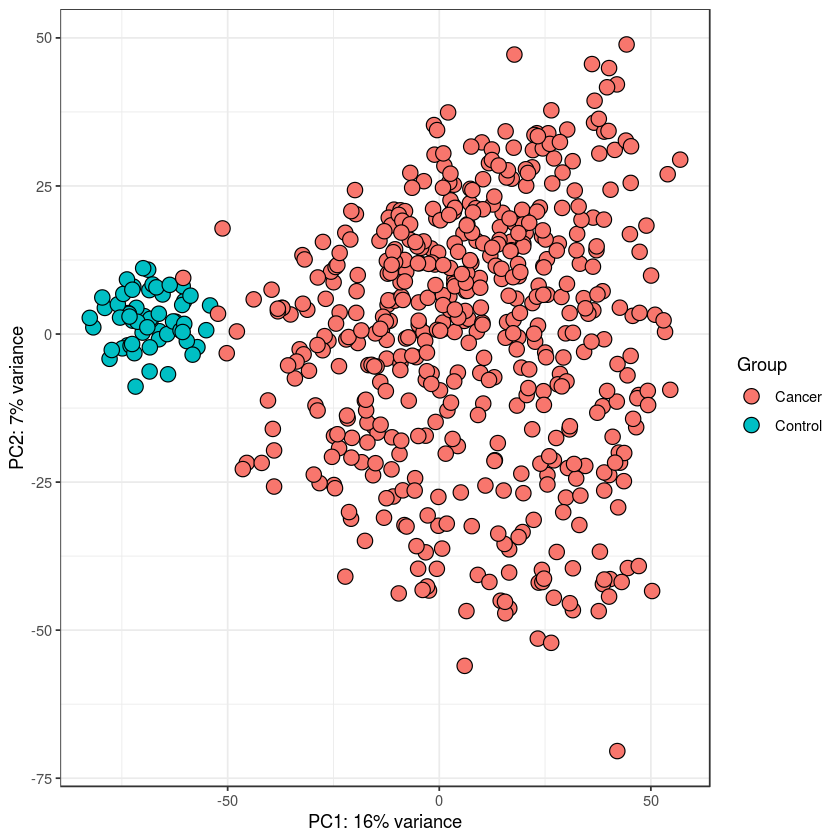

In [228]:
pcaData <- plotPCA(LUAD_ddsMat_rlog, intgroup = c("Group"), ntop = 2000,returnData = F) 
ggplot(pcaData$data, aes(PC1, PC2, fill=Group,labels=Group))+
    theme_bw() + # remove default ggplot2 theme
    #geom_point(aes(shape=group),size = 5) + # Increase point size
    #geom_point(colour="black",size = 4,stroke = 4) + # Increase point size
    geom_point(size = 4, alpha = 1, shape = 21, colour = "black")+
    #scale_x_continuous(limits = c(-200, 200)) + # change limits to fix figure dimensions
    scale_shape_manual(values=seq(1,30))+
    xlab(pcaData$labels$x)+ylab(pcaData$labels$y)

### For TB

In [229]:
LUAD_self <- intersect(row.names(T_N_results_sig),row.names(LUAD_results_sig))

In [230]:
exprSet <- as.data.frame(t(LUAD_rpkm[LUAD_self,row.names(LUAD_info[LUAD_info$Group=="Cancer",])]))
name <- LUAD_info[LUAD_info$Group=="Cancer"&LUAD_info$name %in% row.names(LUAD_stat_sur)&LUAD_info$label=="01",]
exprSet <- exprSet[row.names(name),]
row.names(exprSet) <- unname(lapply(strsplit(row.names(exprSet),"-"),function(x)paste(x[1],x[2],x[3],sep="-")))
exprSet <- cbind(exprSet,LUAD_stat_sur[unlist(name$name),c("OS","vital_status")])

In [232]:
options(scipen=10)
exprSet_data <- exprSet[,1:(ncol(exprSet)-2)]
log_rank_p <- apply(exprSet_data, 2, function(value){
    group <- ifelse(value > median(value),"high","low")
    my.surv <- Surv(exprSet$OS, exprSet$vital_status)
    kmfit <- survfit(my.surv ~ group,data = exprSet)
    data.survdiff <- survdiff(my.surv ~ group)
    p.value <- 1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1)
    HR = (data.survdiff$obs[2]/data.survdiff$exp[2])/(data.survdiff$obs[1]/data.survdiff$exp[1])
    up95 = exp(log(HR) + qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))
    low95 = exp(log(HR) - qnorm(0.975)*sqrt(1/data.survdiff$exp[2]+1/data.survdiff$exp[1]))
    gg <- ggsurvplot(kmfit, conf.int = TRUE,legend.title = "Expression",palette= c("red","blue"),
                    pval = round(p.value,4), ggtheme = theme_bw(),xlab=c("Month"))
    return(list(p.value,gg))
})

In [233]:
data <- data.frame()
pdf("surival-TB.pdf",paper='a4r')
for (i in names(log_rank_p)){
    p <- log_rank_p[i][[1]][[1]]
    if (p<0.05){
    gg <- log_rank_p[i][[1]][[2]]
    title <- unname(mapIds(x = ensdb,keys =i,
                column = "GENENAME",keytype = "GENEID",multiVals = "first"))
    print(gg+ggtitle(title))
    data[i,"ID"] <- title
    data[i,"p"] <- p
    }
    
}
dev.off()

png 
  2

In [234]:
datas <- cbind(data,LUAD_results_sig[row.names(data),"log2FoldChange"])
datas <- cbind(datas,T_N_results_sig[row.names(data),c("log2FoldChange","description")])
datas <- cbind(datas,T_N_results_sig[row.names(data),c("log2FoldChange")])

In [235]:
write.table(datas,"KM-TB.xls",sep = "\t",quote = F)

In [236]:
T_TCGA_genes <- unname(mapIds(x = ensdb,keys =row.names(datas),
                column = "ENTREZID",keytype = "GENEID",multiVals = "first"))
T_TCGA_BP <- enrichGO(gene = T_TCGA_genes,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_TCGA_CC <- enrichGO(gene = T_TCGA_genes,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "CC",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)
T_TCGA_MF <- enrichGO(gene = T_TCGA_genes,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "MF",
                 pAdjustMethod = "BH",
                 qvalueCutoff  = 0.1)

In [237]:
T_TCGA_KEGG <- enrichKEGG(gene = T_TCGA_genes,
                       organism     = 'hsa',
                       pAdjustMethod = "BH",
                       pvalueCutoff = 0.5,
                       qvalueCutoff  = 1, use_internal_data=F)

In [238]:
T_TCGA_reactome <- enrichPathway(gene=T_TCGA_genes,qvalueCutoff=1, organism = "human")

In [239]:
KM_data <- read.table("KM.xls",row.names=1,stringsAsFactors = F,header=F,skip=1,sep="\t")
T_TCGA_expr <- KM_data[,c(3,4,6)]
row.names(T_TCGA_expr)<- KM_data[,1]
colnames(T_TCGA_expr) <- c("LUAD","TB","Cancer")

In [241]:
test <- t(apply(as.matrix(T_TCGA_expr[,c("TB","Cancer","LUAD")]),1,scale,center=F))
pheatmap(mat = test , 
         color = colorRampPalette(c("blue","white","red"))(255),
         scale = "none", # Scale genes to Z-score (how many standard deviations)
         #cluster_rows=hclust(dist(cor(t(mat)),method = "manhattan")),
         cluster_cols=F,
         show_rownames=T,display_numbers = F,
         fontsize = 8,filename="T_TCGA_heatmap.pdf",cellwidth=12,cellheight=8,
         )